In [2]:
%%capture
!pip install datasets

# Synthetic Tabular data Generator

This notebook contains code adapted from [Tabula](https://github.com/zhao-zilong/Tabula/tree/main), a tabular data synthesizer based on the large language model structures.

Some adjustments were made to better suit the specific data requirements and objectives.

Code Modifications:
- _convert_text_to_tabular_data function: Adjusted to allow multiple words as values in each column.
- Handling Missing Values: Originally, the code discarded generated rows with missing values, but for our project, retaining NULL values in certain fields was necessary to mimic the distribution of original data correctly. So, the code adjusted to allow missing values in generated data.
- Sample Generation Issue: The original code did not append samples when generating more than 100, causing output limitations. This issue was resolved to ensure samples are appended correctly in each iteration.

Dataset preprocessing:
- Column Naming: The code assumed single-word column names, conflicting with our dataset’s multi-word headers. Column names were adapted by replacing spaces with underscores.
- Comma Handling: As the model uses commas to separate between generated columns, data containing commas (e.g., in "TAG" or "Job Description" fields) posed issues. To address this, commas in dataset were replaced with semicolons.
- Character Limit: The model encounters errors with entries over 1024 characters which is the maximum token length. To avoid this, records exceeding this character limit were removed from the input to the model.



In [3]:
import os
import json
import random
import logging
import warnings
import numpy as np
import pandas as pd
import typing as tp
from tqdm import tqdm
from datasets import Dataset
import matplotlib.pyplot as plt
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
from torch.utils.data import DataLoader
from scipy.spatial.distance import jensenshannon
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import entropy
from transformers import (Trainer,
                          DataCollatorWithPadding,
                          AutoTokenizer,
                          AutoModelForCausalLM,
                          TrainingArguments,
                          AutoConfig)

os.environ["WANDB_DISABLED"] = "true"

## Utils
This section contains utility functions and helper tools for Tabula synthesizer that streamline and support the main processes in the notebook. 

In [ ]:

def _array_to_dataframe(data: tp.Union[pd.DataFrame, np.ndarray], columns=None) -> pd.DataFrame:
    """ Converts a Numpy Array to a Pandas DataFrame

    Args:
        data: Pandas DataFrame or Numpy NDArray
        columns: If data is a Numpy Array, columns needs to be a list of all column names

    Returns:
        Pandas DataFrame with the given data
    """
    if isinstance(data, pd.DataFrame):
        return data

    assert isinstance(data, np.ndarray), "Input needs to be a Pandas DataFrame or a Numpy NDArray"
    assert columns, "To convert the data into a Pandas DataFrame, a list of column names has to be given!"
    assert len(columns) == len(data[0]), \
        "%d column names are given, but array has %d columns!" % (len(columns), len(data[0]))

    return pd.DataFrame(data=data, columns=columns)


def _get_column_distribution(df: pd.DataFrame, col: str) -> tp.Union[list, dict]:
    """ Returns the distribution of a given column. If continuous, returns a list of all values.
        If categorical, returns a dictionary in form {"A": 0.6, "B": 0.4}

    Args:
        df: pandas DataFrame
        col: name of the column

    Returns:
        Distribution of the column
    """
    if df[col].dtype == "float":
        col_dist = df[col].to_list()
    else:
        col_dist = df[col].value_counts(1).to_dict()
    return col_dist


def _convert_tokens_to_text(tokens: tp.List[torch.Tensor], tokenizer: AutoTokenizer) -> tp.List[str]:
    """ Decodes the tokens back to strings

    Args:
        tokens: List of tokens to decode
        tokenizer: Tokenizer used for decoding

    Returns:
        List of decoded strings
    """
    # Convert tokens to text
    text_data = [tokenizer.decode(t) for t in tokens]

    # Clean text
    text_data = [d.replace("<|endoftext|>", "") for d in text_data]
    text_data = [d.replace("\n", " ") for d in text_data]
    text_data = [d.replace("\r", "") for d in text_data]

    return text_data


def _convert_text_to_tabular_data(text: tp.List[str], df_gen: pd.DataFrame) -> pd.DataFrame:
    """ Converts the sentences back to tabular data

    Args:
        text: List of the tabular data in text form
        df_gen: Pandas DataFrame where the tabular data is appended

    Returns:
        Pandas DataFrame with the tabular data from the text appended
    """
    columns = df_gen.columns.to_list()
    columns = [column.strip() for column in columns]
    result_list = []
    k = 0
    # Convert text to tabular data
    for t in text:
        features = t.split(",")
        td = dict.fromkeys(columns)

        # Transform all features back to tabular data
        for f in features:
            values = f.split(" ")
            # values = f.strip().split(" ")
            if len(values[0]) == 0:
                k = 1
            try:
                if values[k] in columns and not td[values[k]]:
                    try:
                        # td[values[0]] = [values[1]]
                        td[values[k]] = [' '.join(map(str, values[k+1:]))]
                    except IndexError:
                        # print("An Index Error occurred - if this happends a lot, consider fine-tuning your model further.")
                        pass
            except Exception:
                # print('error------', Exception)
                pass
        result_list.append(pd.DataFrame(td, index=[0]))
        # df_gen = pd.concat([df_gen, pd.DataFrame(td)], ignore_index=True, axis=0)

    generated_df = pd.concat(result_list, ignore_index=True, axis=0)
    # df_gen = pd.concat([df_gen, generated_df], ignore_index=True, axis=0)
    # print('generated_df::::::::', td)
    return generated_df

Tabula Trainer

In [ ]:

def _seed_worker(_):
    """
    Helper function to set worker seed during Dataloader initialization.
    """
    worker_seed = torch.initial_seed() % 2**32
    random.seed(worker_seed)
    np.random.seed(worker_seed)
    torch.manual_seed(worker_seed)
    torch.cuda.manual_seed_all(worker_seed)


class TabulaTrainer(Trainer):
    """ Tabula Trainer

    Overwrites the get_train_dataloader methode of the HuggingFace Trainer to not remove the "unused" columns -
    they are needed later!
    """
    def get_train_dataloader(self) -> DataLoader:
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")

        data_collator = self.data_collator
        train_dataset = self.train_dataset  # self._remove_unused_columns(self.train_dataset, description="training")
        train_sampler = self._get_train_sampler()

        return DataLoader(
            train_dataset,
            batch_size=self._train_batch_size,
            sampler=train_sampler,
            collate_fn=data_collator,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
            pin_memory=self.args.dataloader_pin_memory,
            worker_init_fn=_seed_worker,
        )

Tabula start

In [ ]:

def _pad(x, length: int, pad_value=50256):
    """
    Prepend the pad value until the array reaches the specific length
    """
    return [pad_value] * (length - len(x)) + x


#
def _pad_tokens(tokens):
    """
    Checks that all tensors in the list have the same length, pads them if necessary to the max length

    Args:
        tokens: List of Tensors

    Returns:
        List of Tensors, where each Tensor has the same length
    """
    max_length = len(max(tokens, key=len))
    tokens = [_pad(t, max_length) for t in tokens]
    return tokens


class TabulaStart:
    """ Abstract super class Tabula Start

    Tabula Start creates tokens to start the generation process.

    Attributes:
        tokenizer (AutoTokenizer): Tokenizer, automatically downloaded from llm-checkpoint
    """
    def __init__(self, tokenizer):
        """
        Initializes the super class.

        Args:
            tokenizer: Tokenizer from the HuggingFace library
        """
        self.tokenizer = tokenizer

    def get_start_tokens(self, n_samples: int) -> tp.List[tp.List[int]]:
        """ Get Start Tokens

        Creates starting points for the generation process

        Args:
            n_samples: Number of start prompts to create

        Returns:
            List of n_sample lists with tokens
        """
        raise NotImplementedError("This has to be overwritten but the subclasses")


class CategoricalStart(TabulaStart):
    """ Categorical Starting Feature

    A categorical column with its categories is used as starting point.

    Attributes:
        start_col (str): Name of the categorical column
        population (list[str]): Possible values the column can take
        weights (list[float]): Probabilities for the individual categories

    """
    def __init__(self, tokenizer, start_col: str, start_col_dist: dict):
        """ Initializes the Categorical Start

        Args:
            tokenizer: Tokenizer from the HuggingFace library
            start_col: Name of the categorical column
            start_col_dist: Distribution of the categorical column (dict of form {"Cat A": 0.8, "Cat B": 0.2})
        """
        super().__init__(tokenizer)

        assert isinstance(start_col, str), ""
        assert isinstance(start_col_dist, dict), ""

        self.start_col = start_col
        self.population = list(start_col_dist.keys())
        self.weights = list(start_col_dist.values())

    def get_start_tokens(self, n_samples):
        start_words = random.choices(self.population, self.weights, k=n_samples)
        start_text = [self.start_col + " " + str(s) + "," for s in start_words]
        start_tokens = _pad_tokens(self.tokenizer(start_text)["input_ids"])
        return start_tokens


class ContinuousStart(TabulaStart):
    """ Continuous Starting Feature

    A continuous column with some noise is used as starting point.

    Attributes:
        start_col (str): Name of the continuous column
        start_col_dist (list[float]): The continuous column from the train data set
        noise (float): Size of noise that is added to each value
        decimal_places (int): Number of decimal places the continuous values have
    """
    def __init__(self, tokenizer, start_col: str, start_col_dist: tp.List[float],
                 noise: float = .01, decimal_places: int = 5):
        """ Initializes the Continuous Start

        Args:
            tokenizer: Tokenizer from the HuggingFace library
            start_col: Name of the continuous column
            start_col_dist: The continuous column from the train data set
            noise: Size of noise that is added to each value
            decimal_places: Number of decimal places the continuous values have
        """
        super().__init__(tokenizer)

        assert isinstance(start_col, str), ""
        assert isinstance(start_col_dist, list), ""

        self.start_col = start_col
        self.start_col_dist = start_col_dist
        self.noise = noise
        self.decimal_places = decimal_places

    def get_start_tokens(self, n_samples):
        start_words = random.choices(self.start_col_dist, k=n_samples)
        start_text = [self.start_col + " " + format(s, f".{self.decimal_places}f") + "," for s in start_words]
        start_tokens = _pad_tokens(self.tokenizer(start_text)["input_ids"])
        return start_tokens


class RandomStart(TabulaStart):
    """ Random Starting Features

    Random column names are used as start point. Can be used if no distribution of any column is known.

    Attributes:
        all_columns (List[str]): Names of all columns
    """
    def __init__(self, tokenizer, all_columns: tp.List[str]):
        """ Initializes the Random Start

        Args:
            tokenizer: Tokenizer from the HuggingFace library
            all_columns: Names of all columns
        """
        super().__init__(tokenizer)
        self.all_columns = all_columns

    def get_start_tokens(self, n_samples):
        start_words = random.choices(self.all_columns, k=n_samples)
        start_text = [s + " " for s in start_words]
        start_tokens = _pad_tokens(self.tokenizer(start_text)["input_ids"])
        return start_tokens

Tabula dataset

In [ ]:

class TabulaDataset(Dataset):
    """ Tabula Dataset

    The TabulaDataset overwrites the _getitem function of the HuggingFace Dataset Class to include the permutation step.

    Attributes:
        tokenizer (AutoTokenizer): Tokenizer from HuggingFace
    """
    def set_tokenizer(self, tokenizer):
        """ Set the Tokenizer

        Args:
            tokenizer: Tokenizer from HuggingFace
        """
        self.tokenizer = tokenizer

    def _getitem(self, key: tp.Union[int, slice, str], decoded: bool = True, **kwargs) -> tp.Union[tp.Dict, tp.List]:
        """ Get Item from Tabular Data

        Get one instance of the tabular data, permuted, converted to text and tokenized.
        """
        # If int, what else?
        row = self._data.fast_slice(key, 1)

        shuffle_idx = list(range(row.num_columns))
        random.shuffle(shuffle_idx)

        shuffled_text = ", ".join(
            ["%s %s" % (row.column_names[i], str(row.columns[i].to_pylist()[0]).strip()) for i in shuffle_idx]
        )

        tokenized_text = self.tokenizer(shuffled_text)
        return tokenized_text

    def __getitems__(self, keys: tp.Union[int, slice, str, list]):
        if isinstance(keys, list):
            return [self._getitem(key) for key in keys]
        else:
            return self._getitem(keys)

@dataclass
class TabulaDataCollator(DataCollatorWithPadding):
    """ Tabula Data Collator

    Overwrites the DataCollatorWithPadding to also pad the labels and not only the input_ids
    """
    def __call__(self, features: tp.List[tp.Dict[str, tp.Any]]):
        batch = self.tokenizer.pad(
            features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors=self.return_tensors,
        )
        batch["labels"] = batch["input_ids"].clone()
        # Use following print to observe encoded token sequence length
        # print("labels shape: ", batch["labels"].shape)
        return batch

## Tabula Model
This part handles the generation flow. It consists fine-tuning a large language model on tabular data, and to sample synthetic tabular data.

In [ ]:

class Tabula:
    """ Tabula Class

    The Tabula class handles the whole generation flow. It is used to fine-tune a large language model for tabular data,
    and to sample synthetic tabular data.

    Attributes:
        llm (str): HuggingFace checkpoint of a pretrained large language model, used a basis of our model
        tokenizer (AutoTokenizer): Tokenizer, automatically downloaded from llm-checkpoint
        model (AutoModelForCausalLM): Large language model, automatically downloaded from llm-checkpoint
        experiment_dir (str): Directory, where the training checkpoints will be saved
        epochs (int): Number of epochs to fine-tune the model
        batch_size (int): Batch size used for fine-tuning
        train_hyperparameters (dict): Additional hyperparameters added to the TrainingArguments used by the
         HuggingFaceLibrary, see here the full list of all possible values
         https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments
        columns (list): List of all features/columns of the tabular dataset
        num_cols (list): List of all numerical features/columns of the tabular dataset
        conditional_col (str): Name of a feature/column on which the sampling can be conditioned
        conditional_col_dist (dict | list): Distribution of the feature/column specified by condtional_col
    """

    def __init__(self, llm: str, experiment_dir: str = "trainer_tabula", epochs: int = 100,
                 batch_size: int = 8, categorical_columns: list = [], **train_kwargs):
        """ Initializes Tabula.

        Args:
            llm: HuggingFace checkpoint of a pretrained large language model, used a basis of our model
            experiment_dir:  Directory, where the training checkpoints will be saved
            epochs: Number of epochs to fine-tune the model
            batch_size: Batch size used for fine-tuning
            train_kwargs: Additional hyperparameters added to the TrainingArguments used by the HuggingFaceLibrary,
             see here the full list of all possible values
             https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments
        """

        # Load Model and Tokenizer from HuggingFace
        self.llm = llm
        self.tokenizer = AutoTokenizer.from_pretrained(self.llm)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.config = AutoConfig.from_pretrained(self.llm)
        self.model = AutoModelForCausalLM.from_config(self.config)

        # Set the training hyperparameters
        self.experiment_dir = experiment_dir
        self.epochs = epochs
        self.batch_size = batch_size
        self.categorical_columns = categorical_columns
        self.train_hyperparameters = train_kwargs

        # Needed for the sampling process
        self.columns = None
        self.num_cols = None
        self.conditional_col = None
        self.conditional_col_dist = None


    def encode_categorical_column(self, data: pd.DataFrame):
        self.label_encoder_list = []
        for column_index, column in enumerate(data.columns):
            if column in self.categorical_columns:
                label_encoder = preprocessing.LabelEncoder()
                data[column] = data[column].astype(str)
                label_encoder.fit(data[column])
                current_label_encoder = dict()
                current_label_encoder['column'] = column
                current_label_encoder['label_encoder'] = label_encoder
                transformed_column = label_encoder.transform(data[column])
                data[column] = transformed_column
                self.label_encoder_list.append(current_label_encoder)
        return data


    def decode_categorical_column(self, data: pd.DataFrame):

        for i in range(len(self.label_encoder_list)):
            le = self.label_encoder_list[i]["label_encoder"]
            allowed_values = list(range(len(le.classes_)))


            # delete rows that should generate numeric value but generate other data type
            data[self.label_encoder_list[i]['column']] = pd.to_numeric(data[self.label_encoder_list[i]['column']], errors='coerce')
            data = data.dropna(subset=[self.label_encoder_list[i]['column']])
            # print('Decode data2:', data)

            # delete rows that generate category that is out of boundary
            data[self.label_encoder_list[i]['column']] = data[self.label_encoder_list[i]['column']].astype(float)
            data = data[data[self.label_encoder_list[i]['column']].isin(allowed_values)]
            # print('Decode data3:', data)

        for i in range(len(self.label_encoder_list)):
            le = self.label_encoder_list[i]["label_encoder"]
            data[self.label_encoder_list[i]["column"]] = data[self.label_encoder_list[i]["column"]].astype(int)
            data[self.label_encoder_list[i]["column"]] = le.inverse_transform(data[self.label_encoder_list[i]["column"]])

        # print('Decode data4:', data)
        return data



    def fit(self, data: tp.Union[pd.DataFrame, np.ndarray], column_names: tp.Optional[tp.List[str]] = None,
            conditional_col: tp.Optional[str] = None, resume_from_checkpoint: tp.Union[bool, str] = False) \
            -> TabulaTrainer:
        """ Fine-tune Tabula using tabular data.

        Args:
            data: Pandas DataFrame or Numpy Array that contains the tabular data
            column_names: If data is Numpy Array, the feature names have to be defined. If data is Pandas
            DataFrame, the value is ignored
            conditional_col: If given, the distribution of this column is saved and used as a starting
            point for the generation process later. If None, the last column is considered as conditional feature
            resume_from_checkpoint: If True, resumes training from the latest checkpoint in the experiment_dir.
            If path, resumes the training from the given checkpoint (has to be a valid HuggingFace checkpoint!)

        Returns:
            TabulaTrainer used for the fine-tuning process
        """
        df = _array_to_dataframe(data, columns=column_names)
        self._update_column_information(df)
        self._update_conditional_information(df, conditional_col)

        # encoding text to ID for categorical column
        if self.categorical_columns != []:
            df = self.encode_categorical_column(df)

        # Convert DataFrame into HuggingFace dataset object
        logging.info("Convert data into HuggingFace dataset object...")
        tabula_ds = TabulaDataset.from_pandas(df)
        tabula_ds.set_tokenizer(self.tokenizer)

        # Set training hyperparameters
        logging.info("Create Tabula Trainer...")
        training_args = TrainingArguments(self.experiment_dir,
                                          num_train_epochs=self.epochs,
                                          per_device_train_batch_size=self.batch_size,
                                          save_strategy="no",
                                          **self.train_hyperparameters)
        tabula_trainer = TabulaTrainer(self.model, training_args, train_dataset=tabula_ds, tokenizer=self.tokenizer,
                                     data_collator=TabulaDataCollator(self.tokenizer))

        # Start training
        logging.info("Start training...")
        tabula_trainer.train(resume_from_checkpoint=resume_from_checkpoint)
        return tabula_trainer

    def sample(self, n_samples: int,
               start_col: tp.Optional[str] = "", start_col_dist: tp.Optional[tp.Union[dict, list]] = None,
               temperature: float = 0.7, k: int = 100, max_length: int = 100, device: str = "cuda", prompt: str = "") -> pd.DataFrame:
        """ Generate synthetic tabular data samples

        Args:
            n_samples: Number of synthetic samples to generate
            start_col: Feature to use as starting point for the generation process. If not given, the target
             learned during the fitting is used as starting point
            start_col_dist: Feature distribution of the starting feature. Should have the format
             "{F1: p1, F2: p2, ...}" for discrete columns or be a list of possible values for continuous columns.
             If not given, the target distribution learned during the fitting is used as starting point
            temperature: The generation samples each token from the probability distribution given by a softmax
             function. The temperature parameter controls the softmax function. A low temperature makes it sharper
             (0 equals greedy search), a high temperature brings more diversity but also uncertainty into the output.
             See this blog article (https://huggingface.co/blog/how-to-generate) to read more about the generation
             process
            k: Sampling Batch Size. Set as high as possible. Speeds up the generation process significantly
            max_length: Maximal number of tokens to generate - has to be long enough to not cut any information!
            device: Set to "cpu" if the GPU should not be used. You can also specify the concrete GPU

        Returns:
            Pandas DataFrame with n_samples rows of generated data
        """

        tabula_start = self._get_start_sampler(start_col, start_col_dist)

        # Move model to device
        self.model.to(device)

        # Init empty DataFrame for the generated samples
        df_gen = pd.DataFrame(columns=self.columns)

        # prompt_tokens = self.tokenizer.encode(prompt, add_special_tokens=False)

        # Start generation process
        with tqdm(total=n_samples) as pbar:
            already_generated = 0
            while n_samples > df_gen.shape[0]:
                start_tokens = tabula_start.get_start_tokens(k)
                start_tokens = torch.tensor(start_tokens).to(device)

                # Generate tokens
                tokens = self.model.generate(input_ids=start_tokens, max_length=max_length,
                                             do_sample=True, temperature=temperature, pad_token_id=50256)

                # Convert tokens back to tabular data
                text_data = _convert_tokens_to_text(tokens, self.tokenizer)
                df_generated = _convert_text_to_tabular_data(text_data, df_gen)
                
                #Added by Parvaneh
                df_gen = pd.concat([df_gen, df_generated], ignore_index=True)
                
                #Commented by Parvaneh
                # Remove rows with flawed numerical values
                # for i_num_cols in self.num_cols:
                #     df_gen = df_gen[pd.to_numeric(df_gen[i_num_cols], errors='coerce').notnull()]

                #Added by Parvaneh
                df_gen[self.num_cols] = df_gen[self.num_cols].apply(pd.to_numeric, errors='coerce')
                #Added by Parvaneh
                df_gen[self.num_cols] = df_gen[self.num_cols].replace('', np.nan)

                df_gen[self.num_cols] = df_gen[self.num_cols].astype(float)
                
                #Commented by Parvaneh
                # Remove rows with missing values
                # df_gen = df_gen.drop(df_gen[df_gen.isna().any(axis=1)].index)
                
                # Update process bar
                pbar.update(df_gen.shape[0] - already_generated)
                already_generated = df_gen.shape[0]
                print('already_generated::', already_generated)

        df_gen = df_gen.reset_index(drop=True)

        if self.categorical_columns == []:
            return df_gen.head(n_samples)
        else:
            df_inversed = self.decode_categorical_column(df_gen.head(n_samples))
            return df_inversed

    def tabula_sample(self, starting_prompts: tp.Union[str, list[str]], temperature: float = 0.7, max_length: int = 100,
                     device: str = "cuda") -> pd.DataFrame:
        """ Generate synthetic tabular data samples conditioned on a given input.

        Args:
            starting_prompts: String or List of Strings on which the output is conditioned.
             For example, "Sex is female, Age is 26"
            temperature: The generation samples each token from the probability distribution given by a softmax
             function. The temperature parameter controls the softmax function. A low temperature makes it sharper
             (0 equals greedy search), a high temperature brings more diversity but also uncertainty into the output.
             See this blog article (https://huggingface.co/blog/how-to-generate) to read more about the generation
             process.
            max_length: Maximal number of tokens to generate - has to be long enough to not cut any information
            device: Set to "cpu" if the GPU should not be used. You can also specify the concrete GPU.

         Returns:
            Pandas DataFrame with synthetic data generated based on starting_prompts
        """
        # ToDo: Add n_samples argument to generate more samples for one conditional input.

        self.model.to(device)
        starting_prompts = [starting_prompts] if isinstance(starting_prompts, str) else starting_prompts
        generated_data = []

        # Generate a sample for each starting point
        for prompt in tqdm(starting_prompts):
            start_token = torch.tensor(self.tokenizer(prompt)["input_ids"]).to(device)

            # Generate tokens
            gen = self.model.generate(input_ids=torch.unsqueeze(start_token, 0), max_length=max_length,
                                      do_sample=True, temperature=temperature, pad_token_id=50256)

            generated_data.append(torch.squeeze(gen))

        # Convert Text back to Tabular Data
        decoded_data = _convert_tokens_to_text(generated_data, self.tokenizer)
        df_gen = _convert_text_to_tabular_data(decoded_data, pd.DataFrame(columns=self.columns))

        return df_gen

    def save(self, path: str):
        """ Save Tabula Model

        Saves the model weights and a configuration file in the given directory.

        Args:
            path: Path where to save the model
        """
        # Make directory
        if os.path.isdir(path):
            warnings.warn(f"Directory {path} already exists and is overwritten now.")
        else:
            os.mkdir(path)

        # Save attributes
        with open(path + "/config.json", "w") as f:
            attributes = self.__dict__.copy()
            attributes.pop("tokenizer")
            attributes.pop("model")

            # NDArray is not JSON serializable and therefore has to be converted into a list.
            if isinstance(attributes["conditional_col_dist"], np.ndarray):
                attributes["conditional_col_dist"] = list(attributes["conditional_col_dist"])

            json.dump(attributes, f)

        # Save model weights
        torch.save(self.model.state_dict(), path + "/model.pt")

    def load_finetuned_model(self, path: str):
        """ Load fine-tuned model

        Load the weights of a fine-tuned large language model into the Tabula pipeline

        Args:
            path: Path to the fine-tuned model
        """
        self.model.load_state_dict(torch.load(path))

    @classmethod
    def load_from_dir(cls, path: str):
        """ Load Tabula class

        Load trained Tabula model from directory.

        Args:
            path: Directory where Tabula model is saved

        Returns:
            New instance of Tabula loaded from directory
        """
        assert os.path.isdir(path), f"Directory {path} does not exist."

        # Load attributes
        with open(path + "/config.json", "r") as f:
            attributes = json.load(f)

        # Create new be_tabula model instance
        tabula = cls(attributes["llm"])

        # Set all attributes
        for k, v in attributes.items():
            setattr(tabula, k, v)

        # Load model weights
        tabula.model.load_state_dict(torch.load(path + "/model.pt", map_location="cpu"))

        return tabula

    def _update_column_information(self, df: pd.DataFrame):
        # Update the column names (and numerical columns for some sanity checks after sampling)
        self.columns = df.columns.to_list()
        self.num_cols = df.select_dtypes(include=np.number).columns.to_list()

    def _update_conditional_information(self, df: pd.DataFrame, conditional_col: tp.Optional[str] = None):
        assert conditional_col is None or isinstance(conditional_col, str), \
            f"The column name has to be a string and not {type(conditional_col)}"
        assert conditional_col is None or conditional_col in df.columns, \
            f"The column name {conditional_col} is not in the feature names of the given dataset"

        # Take the distribution of the conditional column for a starting point in the generation process
        self.conditional_col = conditional_col if conditional_col else df.columns[-1]
        self.conditional_col_dist = _get_column_distribution(df, self.conditional_col)

    def _get_start_sampler(self, start_col: tp.Optional[str],
                           start_col_dist: tp.Optional[tp.Union[tp.Dict, tp.List]]) -> TabulaStart:
        if start_col and start_col_dist is None:
            raise ValueError(f"Start column {start_col} was given, but no corresponding distribution.")
        if start_col_dist is not None and not start_col:
            raise ValueError(f"Start column distribution {start_col} was given, the column name is missing.")

        assert start_col is None or isinstance(start_col, str), \
            f"The column name has to be a string and not {type(start_col)}"
        assert start_col_dist is None or isinstance(start_col_dist, dict) or isinstance(start_col_dist, list), \
            f"The distribution of the start column on has to be a list or a dict and not {type(start_col_dist)}"

        start_col = start_col if start_col else self.conditional_col
        start_col_dist = start_col_dist if start_col_dist else self.conditional_col_dist

        if isinstance(start_col_dist, dict):
            return CategoricalStart(self.tokenizer, start_col, start_col_dist)
        elif isinstance(start_col_dist, list):
            return ContinuousStart(self.tokenizer, start_col, start_col_dist)
        else:
            return RandomStart(self.tokenizer, self.columns)

## JSD Distribution
The Jensen-Shannon Divergence distribution is defined here for measuring probability distribution of columns in the dataset and generated data. We use it for having a more detailed overview of the characteristics of our data. 

In [10]:
def evaluate_jsd_scipy(data, column):
    value_counts = data[column].value_counts(normalize=True)
    observed = value_counts.values

    num_categories = len(observed)
    expected = np.ones(num_categories) / num_categories  # Uniform distribution

    jsd = jensenshannon(observed, expected)

    return jsd, value_counts

def plot_distribution(ax, value_counts, column_name, jsd_value, threshold=0.07):
    """Plot the percentage distribution of a categorical column and display values on top, with threshold."""
    # Filter out values below the threshold
    filtered_counts = value_counts[value_counts >= threshold]

    bars = filtered_counts.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax)

    for i, val in enumerate(filtered_counts):
        bars.text(i, val, f'{val:.2f}%', ha='center', va='bottom', fontsize=12, color='black')

    # Set title and labels for the subplot
    ax.set_title(f'{column_name} (JSD: {jsd_value:.4f})', fontsize=14)
    ax.set_ylabel('Percentage', fontsize=12)
    ax.set_xticklabels(filtered_counts.index, rotation=45, ha="right")

def evaluate_and_plot_columns(df, columns, c=5):
    """Evaluate bias (JSD) for multiple columns and plot their distributions."""
    # Set up the figure and subplots
    num_columns = len(columns)
    fig, axs = plt.subplots(1, num_columns, figsize=(c * num_columns, 6))

    # If only one column, make axs iterable
    if num_columns == 1:
        axs = [axs]

    # Iterate through columns and plot each one
    for i, column in enumerate(columns):
        # Calculate JSD and get category distribution
        jsd_value, value_counts = evaluate_jsd_scipy(df, column)

        # Convert value counts to percentages
        value_counts_percentage = value_counts * 100
        # print(value_counts_percentage)
        # Plot the distribution for each column on its corresponding subplot
        plot_distribution(axs[i], value_counts_percentage, column, jsd_value)

    plt.tight_layout()
    plt.show()

## KL Divergence
Here, we define Kullback-Leibler (KL) Divergence to measure the similarity between the distributions of original data and synthetic generated data. KL Divergence provides a way to quantify how much the generated data deviates from the original data distribution for each feature.
A lower KL Divergence indicates that the generated data closely approximates the distribution of the original data.

We calculte this measure for categorical columns and visualize output through a plot.


In [ ]:
# The textual fields of the dataset which is skipped in KL divergence calculation:
# 'linked_search__key','TAG','Job_Description', 'Candidate_Profile', 'Recruitment_Request',  'Last_Role','Job_Title_Hiring'

categorical_columns = ['Candidate_state','Age_range','Citizenship','Sex', 'Protected_Category', 'Study_area', 'Study_Title',
                       'Years_Experience', 'Sector', 'Year_of_insertion', 'Year_of_Recruitment', 'Assumption_Headquarters',
                       'Job_Family_Hiring', 'event_type__val', 'event_feedback', 'Overall', 'Years_Experience_1', 'Minimum_Ral',
                       'Ral_Maximum', 'Study_Level', 'Study_Area_1', 'Akkodis_headquarters', 'Current_Ral', 'Expected_Ral',
                       'Technical_Skills', 'Standing_Position', 'Comunication', 'Maturity', 'Dynamism', 'Mobility', 'English'
                    ]


# Function to calculate KL divergence for a single categorical column
def calculate_kl_divergence(original_col, synthetic_col):
    # Calculate value counts (frequency distribution) for each dataset
    original_dist = original_col.value_counts(normalize=True)
    synthetic_dist = synthetic_col.value_counts(normalize=True)

    # Align indices, filling missing categories with zero
    all_categories = original_dist.index.union(synthetic_dist.index)
    original_dist = original_dist.reindex(all_categories, fill_value=0)
    synthetic_dist = synthetic_dist.reindex(all_categories, fill_value=0)

    # Calculate KL divergence (adding a small constant to avoid division by zero)
    kl_div = entropy(original_dist + 1e-10, synthetic_dist + 1e-10)
    return kl_div

def show_kl_result(results):
    # Convert results to DataFrame and sort
    kl_df = pd.DataFrame(results)
    kl_df = kl_df.sort_values(by="KL Divergence", ascending=True)
    print(kl_df)

    # Define threshold and create figure
    threshold = 0.2
    plt.figure(figsize=(10, 8))  # Increased figure height for more space

    # Generate spaced y positions without changing bar size
    y_positions = range(len(kl_df))  # Base y positions for each bar
    spacing = 0.6  # Extra spacing between bars

    # Loop over each row to create bars with two tones
    for i, (pos, row) in enumerate(zip(y_positions, kl_df.itertuples())):
        actual_pos = pos * (1 + spacing)  # Apply spacing multiplier to each position
        if row._2 <= threshold:
            plt.barh(actual_pos, row._2, color='skyblue')  # Full bar in blue if below threshold
        else:
            plt.barh(actual_pos, threshold, color='skyblue')
            plt.barh(actual_pos, row._2 - threshold, left=threshold, color='orange')

    # Customizing ticks and labels
    plt.yticks([p * (1 + spacing) for p in y_positions], kl_df["Column"])  # Apply spacing to y-ticks
    plt.xlabel("KL Divergence")
    plt.ylabel("Categorical Columns")
    plt.title("KL Divergence of Categorical Columns (Highlighting Values Over 0.2)")
    plt.gca().invert_yaxis()  # To show lowest KL values at the top
    plt.show()

## Dataset

In [5]:
# relative_path = '/content/drive/MyDrive/AI_Industry/data/Dataset_1.0_Akkodis_3.xlsx'
relative_path = 'data/Dataset_1.0_Akkodis_3.xlsx'
absolute_path = os.path.abspath(relative_path)
data = pd.read_excel(absolute_path)
data = data.astype(str).drop_duplicates()
len(data)

21377

Remove entries longer than max-length of model tokens

In [ ]:
threshold = 1024
length_df = data.applymap(lambda x: len(str(x)))
long_entries = data[(length_df > threshold).any(axis=1)]
data = data[~(length_df > threshold).any(axis=1)]
len(data)

C:\Users\Parvaneh\AppData\Local\Temp\ipykernel_31820\2810940707.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  length_df = data.applymap(lambda x: len(str(x)))


21014

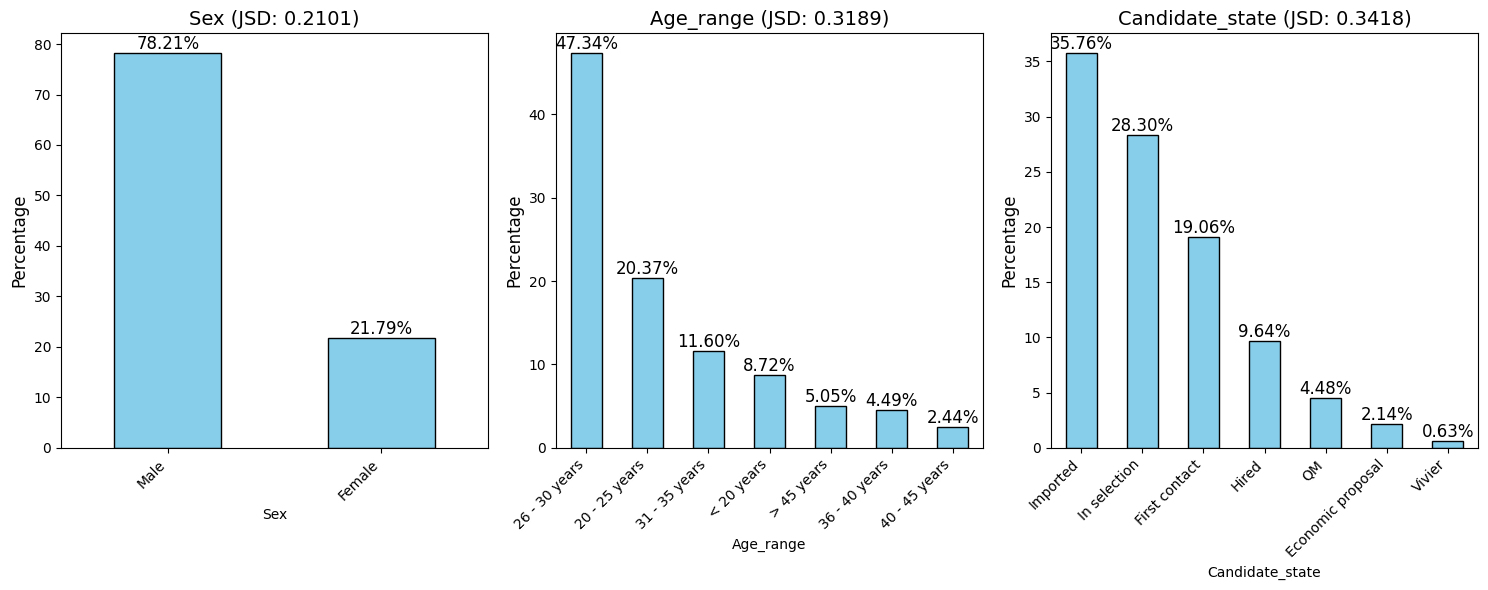

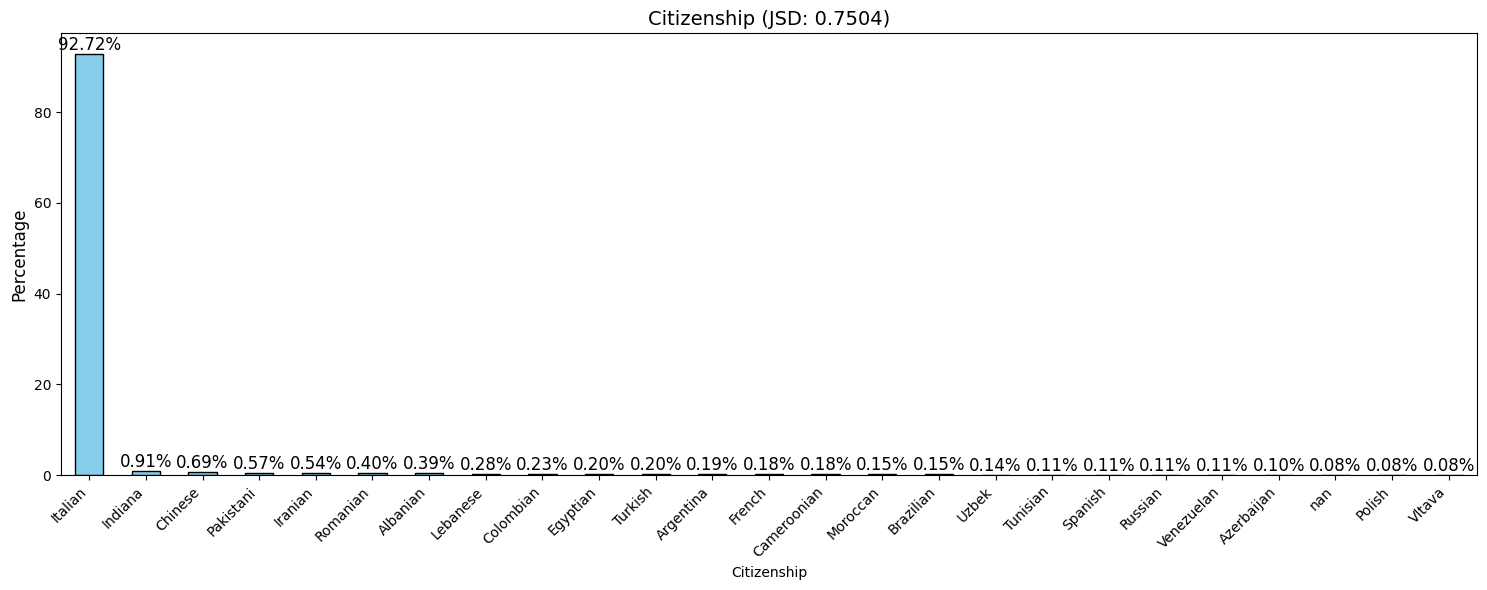

In [ ]:
# Showing JSD distribution for some columns of the dataset
columns_to_evaluate = ['Sex', 'Age_range','Candidate_state']
evaluate_and_plot_columns(data, columns_to_evaluate)

columns_to_evaluate = ['Citizenship']
evaluate_and_plot_columns(data, columns_to_evaluate, c=15)

## Fit Tabula model on the dataset

In [ ]:
model_main = Tabula(llm='distilgpt2', experiment_dir = "training", batch_size=8, epochs=5)

In [ ]:
model_main.fit(data)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
#Sampling the synthetic data
synthetic_data_main = model_main.sample(n_samples=5000, max_length=1024, k=100)

  2%|▏         | 100/5000 [00:15<12:41,  6.44it/s]

already_generated:: 100


  4%|▍         | 200/5000 [00:30<12:05,  6.62it/s]

already_generated:: 200


  6%|▌         | 300/5000 [00:44<11:26,  6.85it/s]

already_generated:: 300


  8%|▊         | 400/5000 [01:05<13:11,  5.81it/s]

already_generated:: 400


 10%|█         | 500/5000 [01:22<12:57,  5.79it/s]

already_generated:: 500


 12%|█▏        | 600/5000 [01:37<12:02,  6.09it/s]

already_generated:: 600


 14%|█▍        | 700/5000 [01:47<10:09,  7.05it/s]

already_generated:: 700


 16%|█▌        | 800/5000 [02:00<09:45,  7.17it/s]

already_generated:: 800


 18%|█▊        | 900/5000 [02:18<10:17,  6.63it/s]

already_generated:: 900


 20%|██        | 1000/5000 [02:31<09:39,  6.91it/s]

already_generated:: 1000


 22%|██▏       | 1100/5000 [02:51<10:34,  6.14it/s]

already_generated:: 1100


 24%|██▍       | 1200/5000 [03:11<11:02,  5.73it/s]

already_generated:: 1200


 26%|██▌       | 1300/5000 [03:25<10:00,  6.16it/s]

already_generated:: 1300


 28%|██▊       | 1400/5000 [03:36<08:45,  6.85it/s]

already_generated:: 1400


 30%|███       | 1500/5000 [03:52<08:50,  6.60it/s]

already_generated:: 1500


 32%|███▏      | 1600/5000 [04:02<07:41,  7.37it/s]

already_generated:: 1600


 34%|███▍      | 1700/5000 [04:14<07:08,  7.70it/s]

already_generated:: 1700


 36%|███▌      | 1800/5000 [04:32<07:42,  6.91it/s]

already_generated:: 1800


 38%|███▊      | 1900/5000 [04:46<07:27,  6.93it/s]

already_generated:: 1900


 40%|████      | 2000/5000 [04:54<06:18,  7.93it/s]

already_generated:: 2000


 42%|████▏     | 2100/5000 [05:02<05:25,  8.90it/s]

already_generated:: 2100


 44%|████▍     | 2200/5000 [05:22<06:27,  7.22it/s]

already_generated:: 2200


 46%|████▌     | 2300/5000 [05:32<05:43,  7.86it/s]

already_generated:: 2300


 48%|████▊     | 2400/5000 [05:49<05:59,  7.22it/s]

already_generated:: 2400


 50%|█████     | 2500/5000 [06:09<06:30,  6.40it/s]

already_generated:: 2500


 52%|█████▏    | 2600/5000 [06:26<06:24,  6.24it/s]

already_generated:: 2600


 54%|█████▍    | 2700/5000 [06:42<06:10,  6.20it/s]

already_generated:: 2700


 56%|█████▌    | 2800/5000 [07:04<06:33,  5.60it/s]

already_generated:: 2800


 58%|█████▊    | 2900/5000 [07:18<05:51,  5.97it/s]

already_generated:: 2900


 60%|██████    | 3000/5000 [07:33<05:23,  6.17it/s]

already_generated:: 3000


 62%|██████▏   | 3100/5000 [07:51<05:18,  5.97it/s]

already_generated:: 3100


 64%|██████▍   | 3200/5000 [08:00<04:21,  6.87it/s]

already_generated:: 3200


 66%|██████▌   | 3300/5000 [08:12<03:51,  7.35it/s]

already_generated:: 3300


 68%|██████▊   | 3400/5000 [08:22<03:20,  7.98it/s]

already_generated:: 3400


 70%|███████   | 3500/5000 [08:43<03:48,  6.57it/s]

already_generated:: 3500


 72%|███████▏  | 3600/5000 [09:00<03:37,  6.43it/s]

already_generated:: 3600


 74%|███████▍  | 3700/5000 [09:16<03:26,  6.30it/s]

already_generated:: 3700


 76%|███████▌  | 3800/5000 [09:36<03:24,  5.87it/s]

already_generated:: 3800


 78%|███████▊  | 3900/5000 [09:52<03:04,  5.95it/s]

already_generated:: 3900


 80%|████████  | 4000/5000 [10:08<02:46,  6.00it/s]

already_generated:: 4000


 82%|████████▏ | 4100/5000 [10:29<02:39,  5.64it/s]

already_generated:: 4100


 84%|████████▍ | 4200/5000 [10:49<02:27,  5.44it/s]

already_generated:: 4200


 86%|████████▌ | 4300/5000 [11:11<02:16,  5.13it/s]

already_generated:: 4300


 88%|████████▊ | 4400/5000 [11:23<01:44,  5.76it/s]

already_generated:: 4400


 90%|█████████ | 4500/5000 [11:40<01:26,  5.78it/s]

already_generated:: 4500


 92%|█████████▏| 4600/5000 [11:57<01:08,  5.87it/s]

already_generated:: 4600


 94%|█████████▍| 4700/5000 [12:10<00:47,  6.28it/s]

already_generated:: 4700


 96%|█████████▌| 4800/5000 [12:28<00:32,  6.07it/s]

already_generated:: 4800


 98%|█████████▊| 4900/5000 [12:44<00:16,  6.04it/s]

already_generated:: 4900


100%|██████████| 5000/5000 [12:57<00:00,  6.43it/s]

already_generated:: 5000


In [ ]:
synthetic_data_main.to_excel('/content/drive/MyDrive/AI_Industry/Output/generated_main_5000.xlsx', index=False)
synthetic_data_main.to_pickle('/content/drive/MyDrive/AI_Industry/Output/generated_main_5000.pkl')

In [ ]:
synthetic_data_main

code     ID Candidate_state      Age_range Citizenship  \
0      8850  65155        Imported  26 - 30 years     Italian   
1      8095    526    In selection  26 - 30 years     Italian   
2     10398  58298        Imported  20 - 25 years     Italian   
3      4386  60229    In selection  26 - 30 years     Italian   
4     13861  48152        Imported  26 - 30 years     Italian   
...     ...    ...             ...            ...         ...   
2995   1142  15448    In selection  20 - 25 years     Italian   
2996  11409  70160    In selection  26 - 30 years     Italian   
2997   6361  53732        Imported  26 - 30 years     Italian   
2998   None   2064    In selection     < 20 years     Italian   
2999  12753  63889    In selection  26 - 30 years     Italian   

                                   Residence   Sex Protected_Category  \
0                   TURIN » Turin ~ Piedmont  Male                nan   
1     MONTE ARGENTINO » Benevento ~ Campania  Male                nan   
2                   TURIN » Turin ~ Piedmont  Male               None   
3            SAN GIOVANNI » Catania ~ Sicily  Male               None   
4                     GALLO » Lecce ~ Puglia  Male                nan   
...                                      ...   ...                ...   
2995                TURIN » Turin ~ Piedmont  Male                nan   
2996      VENAFRO » Bologna ~ Emilia Romagna  Male                nan   
2997                TURIN » Turin ~ Piedmont  Male                nan   
2998                     ROME » Rome ~ Lazio  Male                nan   
2999              CATANIA » Catania ~ Sicily  Male                nan   

                                          TAG                      Study_area  \
0                                         nan            computer engineering   
1                              ENG. AEROSPACE          electronic Engineering   
2                                         nan         Information Engineering   
3     C; C++; EMBEDDED; SW DEVELOPER; V&V; SW          electronic Engineering   
4                                         nan          Management Engineering   
...                                       ...                             ...   
2995                                      nan          Mechanical engineering   
2996                                        -          Mechanical engineering   
2997                                     None          Mechanical engineering   
2998                                     None                     Informatics   
2999                                     None  Energy and Nuclear Engineering   

      ... Akkodis_headquarters Current_Ral Expected_Ral Technical_Skills  \
0     ...                  nan        None          nan              nan   
1     ...                  nan         nan          nan                2   
2     ...                  nan         nan          nan              nan   
3     ...                  nan         nan          nan              nan   
4     ...                  nan         nan          nan              nan   
...   ...                  ...         ...          ...              ...   
2995  ...                  nan         nan          nan              nan   
2996  ...                  nan         nan          nan                2   
2997  ...                  nan         nan          nan              nan   
2998  ...                  nan         nan          nan              nan   
2999  ...                  nan         nan          nan              nan   

     Standing_Position Comunication Maturity Dynamism Mobility English  
0                  nan          nan      nan      nan      nan     nan  
1                  3.0          3.0      3.0      3.0      3.0     3.0  
2                  nan          nan      nan      nan      nan     nan  
3                  nan          nan      nan      nan      nan     nan  
4                  nan          nan      nan      nan      nan     nan  
...                ...   

## Statistics on the generated data

                     Column  KL Divergence
29                 Mobility       0.007864
25        Standing_Position       0.010475
26             Comunication       0.010527
28                 Dynamism       0.012573
4        Protected_Category       0.012714
3                       Sex       0.015271
24         Technical_Skills       0.016953
9         Year_of_insertion       0.044991
27                 Maturity       0.052904
15                  Overall       0.060036
6               Study_Title       0.061172
10      Year_of_Recruitment       0.065858
16       Years_Experience_1       0.067963
14           event_feedback       0.069951
13          event_type__val       0.085441
12        Job_Family_Hiring       0.089079
17              Minimum_Ral       0.089194
0           Candidate_state       0.097223
11  Assumption_Headquarters       0.109914
19              Study_Level       0.110483
1                 Age_range       0.115405
21     Akkodis_headquarters       0.123803
8          

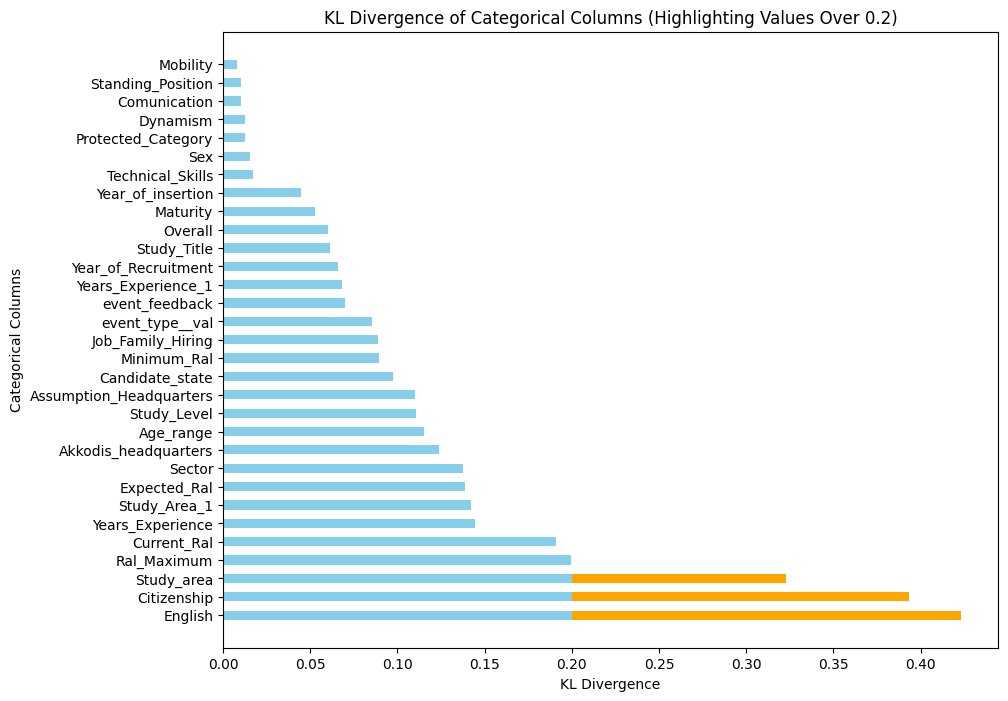

In [ ]:
original_data = data
synthetic_data = synthetic_data_main

results = []
for col in categorical_columns:
    kl_div = calculate_kl_divergence(original_data[col], synthetic_data[col])
    results.append({"Column": col, "KL Divergence": kl_div})

show_kl_result(results)

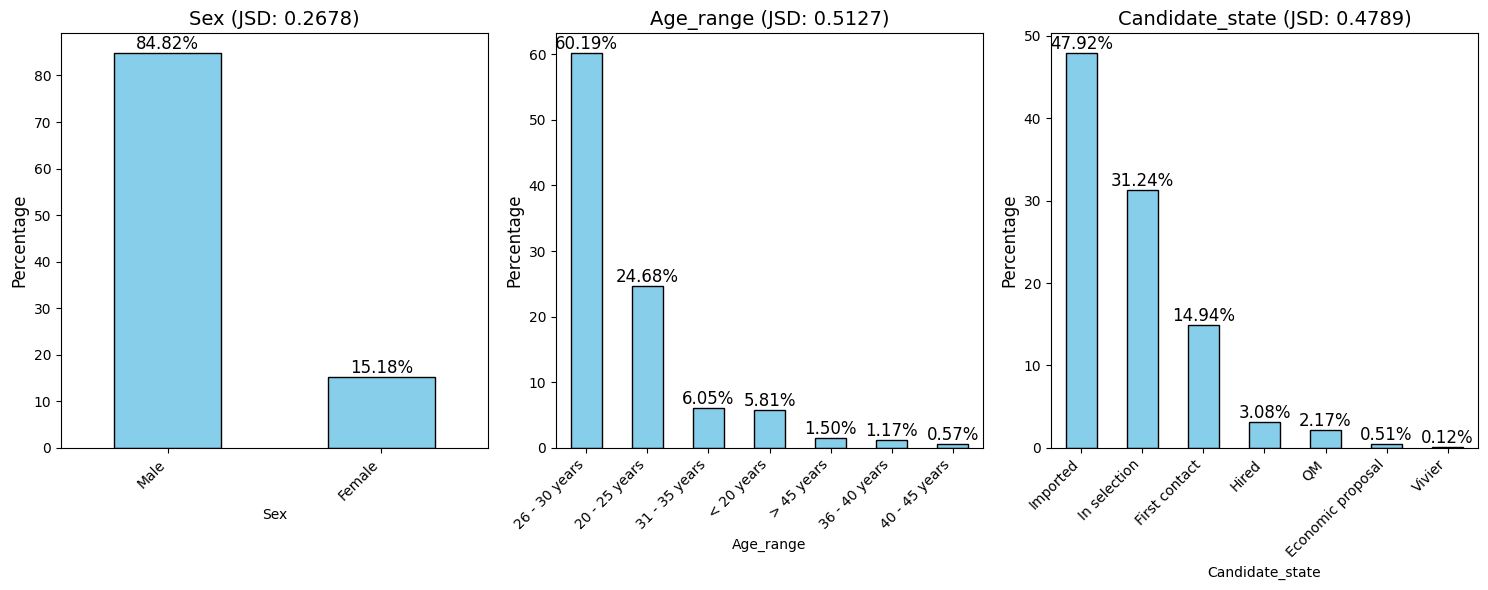

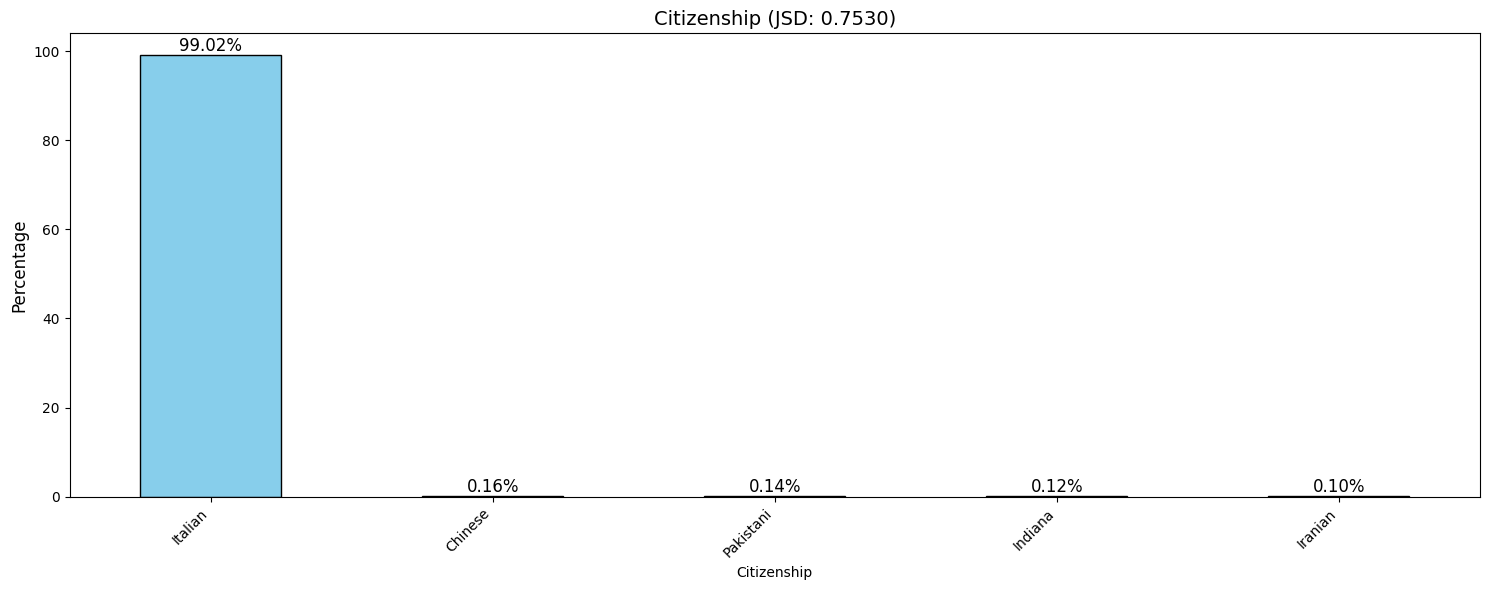

In [ ]:
columns_to_evaluate = ['Sex', 'Age_range','Candidate_state']
evaluate_and_plot_columns(synthetic_data_main, columns_to_evaluate)

columns_to_evaluate = ['Citizenship']
evaluate_and_plot_columns(synthetic_data_main, columns_to_evaluate, c=15)

## Data - Equally sampled with respect to sex
Gender bias Mitigation Strategy:
To reduce bias, we created a balanced dataset with equal representation of gender. By sampling 9,156 records with a 50-50 split between male and female, we aim to provide the model with fairer input data, promoting more equitable learning outcomes.


In [ ]:
male_df = data[data['Sex'] == 'Male']
female_df = data[data['Sex'] == 'Female']

min_size = min(len(male_df), len(female_df))

male_sample = male_df.sample(n=min_size, random_state=42)
female_sample = female_df.sample(n=min_size, random_state=42)

data_equal = pd.concat([male_sample, female_sample])
data_equal

code     ID    Candidate_state      Age_range Citizenship  \
19142  19142  35097           Imported  20 - 25 years     Italian   
11600  11600  15526       In selection  20 - 25 years     Italian   
2886    2886  46769       In selection     > 45 years     Italian   
13050  13050  79833       In selection  26 - 30 years   Colombian   
13799  13799  66990  Economic proposal     > 45 years     Italian   
...      ...    ...                ...            ...         ...   
20696  20696  53407       In selection     < 20 years     Italian   
2297    2297  45065              Hired  26 - 30 years     Italian   
14222  14222  28968           Imported  26 - 30 years     Italian   
17202  17202  61456       In selection  26 - 30 years     Italian   
4663    4663  15722           Imported  26 - 30 years     Italian   

                                       Residence     Sex Protected_Category  \
19142                  RIVOLI » Turin ~ Piedmont    Male                nan   
11600                        ROME » Rome ~ Lazio    Male                nan   
2886                    MILAN » Milan ~ Lombardy    Male                nan   
13050                 NAPLES » Naples ~ Campania    Male                nan   
13799  REPUBLIC OF POLAND » (STATE) ~ (OVERSEAS)    Male                nan   
...                                          ...     ...                ...   
20696         BOLOGNA » Bologna ~ Emilia Romagna  Female                nan   
2297                    TURIN » Turin ~ Piedmont  Female                nan   
14222  BARLETTA » Barletta-Andria-Trani ~ Puglia  Female                nan   
17202         CARNATE » Monza-Brianza ~ Lombardy  Female                nan   
4663                    TURIN » Turin ~ Piedmont  Female                nan   

                                                     TAG  \
19142                                                nan   
11600  SOLIDWORKS, CREO, CATIA, AUTOCAD, CAD, CAD FEM...   
2886                                           MACHINERY   
13050                                                nan   
13799                 E&I SUPERINTENDENT OFF-SHORE; FPSO   
...                                                  ...   
20696                                                  X   
2297   DATA ANALYSIS, SOLIDWORKS, EXCEL, OFFICE, NX, ...   
14222                                                nan   
17202                                                nan   
4663                                                 nan   

                                Study_area  ... Akkodis_headquarters  \
19142                 computer engineering  ...                  nan   
11600               Mechanical engineering  ...                  nan   
2886                              Surveyor  ...                  nan   
13050  Automation/Mechatronics Engineering  ...                  nan   
13799               Electrical Engineering  ...                  nan   
...                                    ...  ...                  ...   
20696                 computer engineering  ...                  nan   
2297                Automotive Engineering  ...                Turin   
14222               Mechanical engineering  ...                  nan   
17202            Other scientific subjects  ...                  nan   
4663                industrial engineering  ...                  nan   

         Current_Ral   Expected_Ral Technical_Skills Standing_Position  \
19142            nan            nan              nan               nan   
11600  Not available  Not available                2               2.0   
2886             nan            nan              nan               nan   
13050            nan            nan                2               2.0   
13799            nan            nan              nan               nan   
...              ...            ...              ...               ...   
20696  Not available  Not available                2               3.0   
2297             nan            nan                2

In [ ]:
# data_equal.to_excel('/content/drive/MyDrive/AI_Industry/Output/dataset_Equal1.xlsx', index=False)

                  Column  KL Divergence
20              Maturity       0.000686
21              Dynamism       0.000780
15               English       0.000783
7      Year_of_insertion       0.000810
8    Year_of_Recruitment       0.000864
16              Mobility       0.000962
18     Standing_Position       0.001298
19          Comunication       0.001338
17      Technical_Skills       0.001348
11        event_feedback       0.001371
4            Study_Title       0.001407
12               Overall       0.001565
9      Job_Family_Hiring       0.002044
10       event_type__val       0.002567
14           Current_Ral       0.002746
6       Years_Experience       0.003024
2              Age_range       0.003030
1        Candidate_state       0.004498
13  Akkodis_headquarters       0.006816
5                 Sector       0.009026
3             Study_area       0.032370
0                    Sex       0.168968


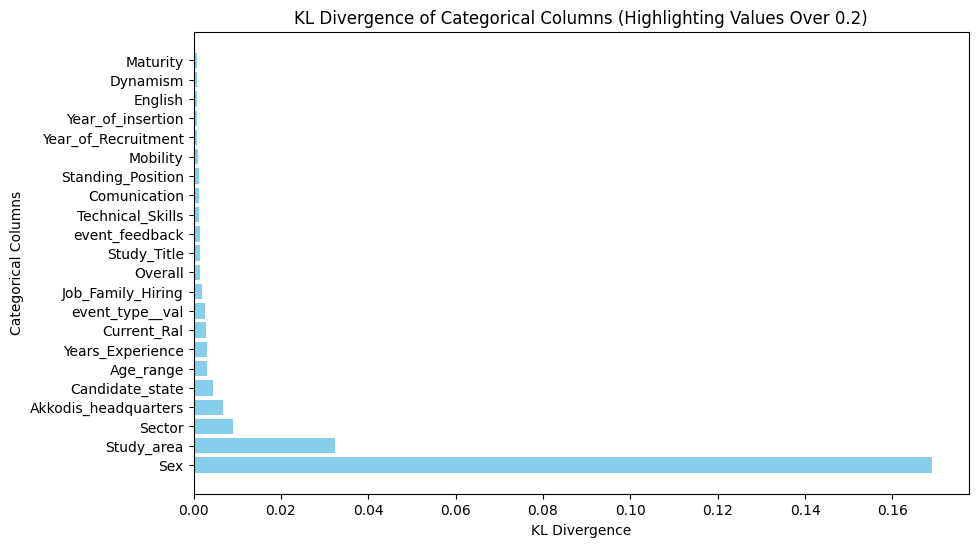

In [ ]:
# Here we examine the KL divergence between the original dataset and the equally sampled data 
# to ensure the sampled data maintains a similar distribution. 
# Notably, the "Sex" field shows a relatively high divergence, while other fields 
# closely match the distribution of the original dataset.

original_data = data
synthetic_data = data_equal

results = []
for col in categorical_columns:
    kl_div = calculate_kl_divergence(original_data[col], synthetic_data[col])
    results.append({"Column": col, "KL Divergence": kl_div})

show_kl_result(results)

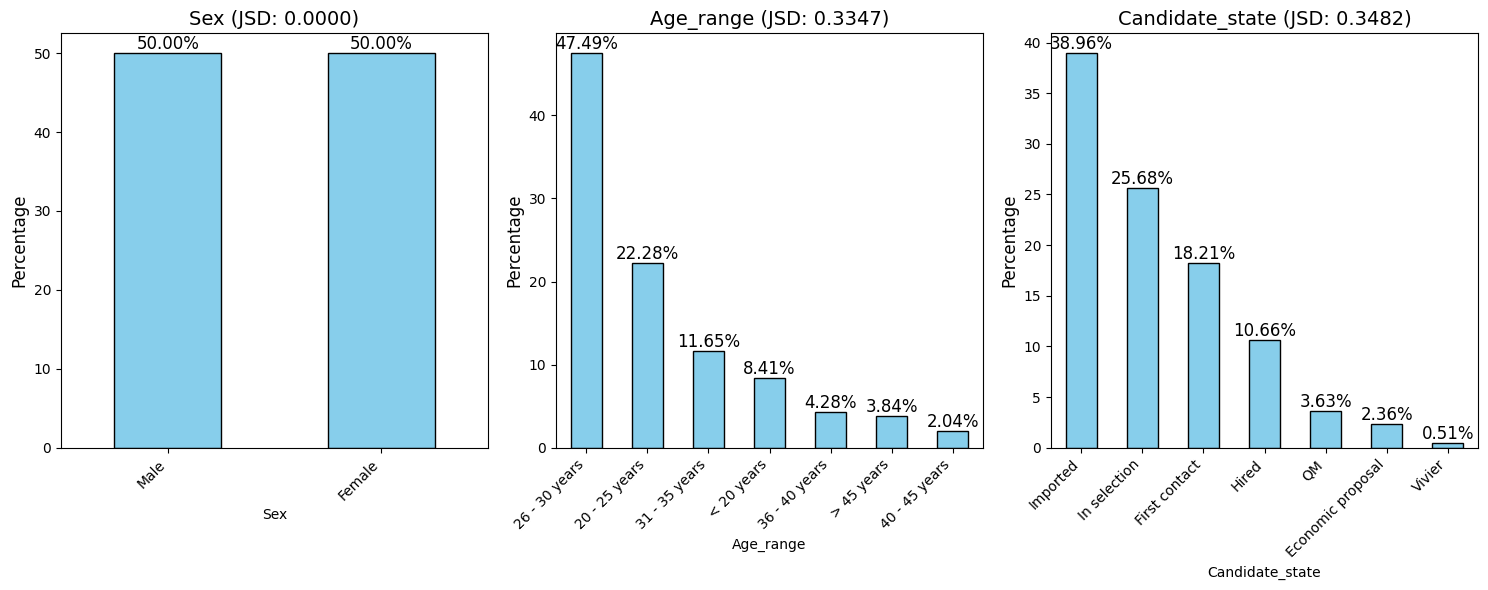

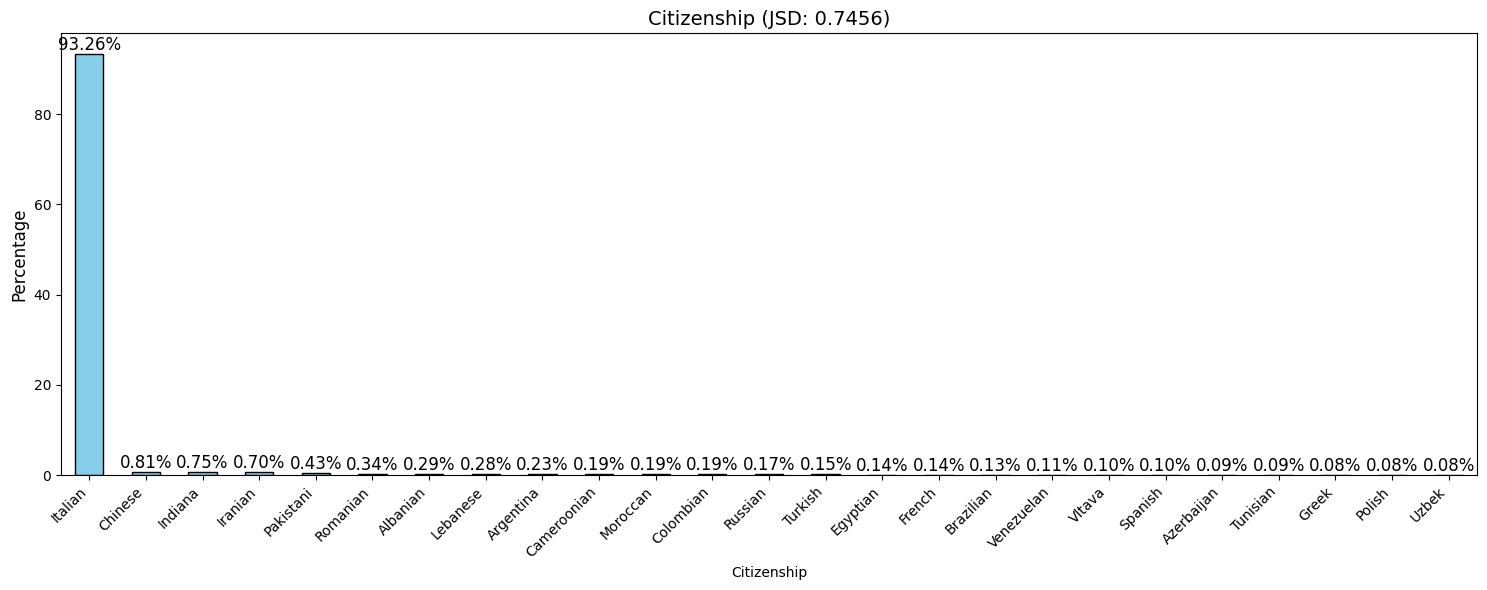

In [ ]:
columns_to_evaluate = ['Sex', 'Age_range','Candidate_state']
evaluate_and_plot_columns(data_equal, columns_to_evaluate)

columns_to_evaluate = ['Citizenship']
evaluate_and_plot_columns(data_equal, columns_to_evaluate, c=15)

## Fit on the sampled data

In [ ]:
model_equal = Tabula(llm='distilgpt2', experiment_dir = "training", batch_size=8, epochs=10)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
model_equal.fit(data_equal)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
synthetic_data3 = model_equal.sample(n_samples=5000, max_length=1024, k=100)

  2%|▏         | 100/5000 [00:19<15:55,  5.13it/s]

text:::::::: ['English nan, Job_Family_Hiring nan, TAG nan, Current_Ral nan, Years_Experience_1 nan, Job_Title_Hiring nan, Study_Level nan, Standing_Position nan, Study_Title Five-year degree, Candidate_state Imported, Years_Experience [0], Overall nan, Year_of_insertion [2022], Maturity nan, Sex Male, ID 51684, code 15227, Technical_Skills nan, Sector nan, Ral_Maximum nan, Year_of_Recruitment nan, Study_Area_1 nan, Assumption_Headquarters nan, Comunication nan, Recruitment_Request nan, Expected_Ral nan, linked_search__key nan, Study_area Energy and Nuclear Engineering, Residence CHIERI » Turin ~ Piedmont, Mobility nan, English nan, Akkodis_headquarters nan, Candidate_Profile nan, Last_Role nan, event_feedback nan, Citizenship Italian, Dynamism nan, Age_range 26 - 30 years, Job_Description nan, Minimum_Ral nan, Protected_Category nan, __index_level_0__ 15139', 'English 3.0, code 9769, Job_Title_Hiring nan, event_feedback OK, Ral_Maximum nan, Study_Area_1 nan, TAG -, nan, event_type__va

  4%|▍         | 200/5000 [00:41<16:40,  4.80it/s]

text:::::::: ['English nan, Current_Ral nan, Age_range 26 - 30 years, Maturity nan, Years_Experience [0], Year_of_Recruitment nan, event_feedback nan, Citizenship Italian, Dynamism nan, Job_Family_Hiring nan, Expected_Ral nan, ID 71720, Mobility nan, Ral_Maximum nan, Study_area Biomedical Engineering, Minimum_Ral nan, Last_Role nan, linked_search__key nan, Recruitment_Request nan, Akkodis_headquarters nan, Years_Experience_1 nan, Candidate_state First contact, Protected_Category nan, Study_Level nan, __index_level_0__ 7254, Sector nan, Residence TURIN » Turin ~ Piedmont, Standing_Position nan, TAG.; BIOMEDICAL ENGINEERING; MECHANICAL ENGINEERING; V&V;, Overall nan, Job_Description nan, Comunication nan, Technical_Skills nan, Sex Male, Candidate_Profile nan, Study_Title Five-year degree, Study_Area_1 nan, Year_of_insertion [2021], Job_Title_Hiring nan, Assumption_Headquarters nan, event_type__val CV request, code 7881', 'English nan, Current_Ral nan, Sex Male, Job_Description nan, Expec

  6%|▌         | 300/5000 [00:58<15:10,  5.16it/s]

text:::::::: ['English 3.0, Study_Area_1 nan, Year_of_Recruitment nan, Study_Level nan, Expected_Ral nan, linked_search__key RS21.0874, event_type__val BM interview, event_feedback OK, __index_level_0__ 4644, Dynamism 3.0, Current_Ral nan, Last_Role Process Engineer, Maturity 3.0, Sector Space, Recruitment_Request nan, Job_Family_Hiring nan, Citizenship Italian, Candidate_Profile nan, Job_Description nan, Study_Title Three-year degree, Overall ~ 3 - High, Protected_Category nan, Years_Experience [1-3], Job_Title_Hiring nan, Ral_Maximum nan, Comunication 3.0, Minimum_Ral nan, Residence TURIN » Turin ~ Piedmont, ID 47918, Akkodis_headquarters nan, Year_of_insertion [2020], code 793, TAG -, MECHANICAL ENGINEERING, MECHANICAL, MECHANICAL ENGINEER, Study_area Mechanical engineering, Standing_Position 3.0, Sex Male, Years_Experience_1 nan, Candidate_state In selection, Assumption_Headquarters nan, Technical_Skills 3, Mobility 2.0, Age_range 26 - 30 years', 'English nan, Job_Description nan, 

  8%|▊         | 400/5000 [01:14<13:35,  5.64it/s]

text:::::::: ['English nan, Sector Others, Study_Area_1 nan, code 17448, Year_of_insertion [2022], Job_Description nan, Years_Experience_1 nan, ID 58455, Dynamism nan, Standing_Position nan, Recruitment_Request nan, Study_Title Three-year degree, Year_of_Recruitment nan, Candidate_Profile nan, Candidate_state First contact, Protected_Category nan, event_feedback nan, Study_Level nan, Minimum_Ral nan, Citizenship Italian, Last_Role Graduate student, Job_Family_Hiring nan, Years_Experience [0], Sex Female, Comunication nan, linked_search__key nan, Job_Title_Hiring nan, Current_Ral nan, Ral_Maximum nan, Technical_Skills nan, Residence FLORENCE » Florence ~ Tuscany, Maturity nan, Overall nan, Study_area Mechanical engineering, __index_level_0__ 17367, event_type__val nan, Expected_Ral nan, English nan, Assumption_Headquarters nan, TAG nan, Age_range 20 - 25 years, Akkodis_headquarters nan', "English 3.0, Candidate_state Hired, Last_Role nan, Technical_Skills 2, ID 35289, Job_Title_Hiring J

 10%|█         | 500/5000 [01:37<14:57,  5.01it/s]

text:::::::: ['English nan, Job_Description nan, Protected_Category nan, Citizenship Italian, event_type__val CV request, Maturity nan, Study_Level nan, Candidate_state In selection, Last_Role Automation engineer, ID 79428, Job_Title_Hiring nan, Technical_Skills nan, Year_of_Recruitment nan, English nan, Residence TURIN » Turin ~ Piedmont, Years_Experience_1 nan, Years_Experience [0-1], Minimum_Ral nan, Recruitment_Request nan, Candidate_Profile nan, TAG BIOMEDICAL; BIOMEDICAL ENGINEERING; MEDICAL DEVICE; QUALITY ASSURANCE; QUALITY; REGULATORY, Comunication nan, Akkodis_headquarters nan, Assumption_Headquarters nan, Expected_Ral nan, Overall nan, linked_search__key nan, Year_of_insertion [2021], Study_area Biomedical Engineering, Study_Title Five-year degree, Sector Life sciences, Mobility nan, Current_Ral nan, Job_Family_Hiring nan, Dynamism nan, Standing_Position nan, Age_range 26 - 30 years, Study_Area_1 nan, event_feedback nan, Ral_Maximum nan, Sex Male, __index_level_0__ 788', 'En

 12%|█▏        | 600/5000 [01:51<13:07,  5.59it/s]

text:::::::: ['English nan, Years_Experience [0-1], Job_Description nan, Year_of_Recruitment nan, Recruitment_Request nan, Technical_Skills nan, Overall nan, Job_Title_Hiring nan, Sector Others, Year_of_insertion [2023], Job_Family_Hiring nan, Citizenship Italian, __index_level_0__ 21022, Study_area Biomedical Engineering, code 21131, Candidate_Profile nan, Akkodis_headquarters nan, Mobility nan, Sex Male, TAG nan, Ral_Maximum nan, Residence TURIN » Turin ~ Piedmont, Minimum_Ral nan, ID 48633, linked_search__key nan, Assumption_Headquarters nan, Comunication nan, Protected_Category nan, Study_Area_1 nan, Current_Ral nan, Standing_Position nan, Study_Title Three-year degree, Last_Role Student, Years_Experience_1 nan, event_type__val nan, Study_Level nan, event_feedback nan, English nan, Candidate_state First contact, Maturity nan, Dynamism nan, Age_range 20 - 25 years, Expected_Ral nan', 'English nan, Job_Title_Hiring nan, Years_Experience [0], Akkodis_headquarters nan, __index_level_0_

 14%|█▍        | 700/5000 [02:08<12:35,  5.69it/s]

text:::::::: ['English nan, Minimum_Ral nan, Years_Experience [0], Last_Role nan, Study_area Aeronautical/Aerospace/Astronautics Engineering, code 10206, Overall nan, Job_Family_Hiring nan, Study_Title_Area_1 nan, Year_of_Recruitment nan, Assumption_Headquarters nan, event_feedback nan, Sex Male, event_type__val CV request, Comunication nan, Residence CHIVASSO » Turin ~ Piedmont, Year_of_insertion [2022], Protected_Category nan, Ral_Maximum nan, English nan, TAG nan, Study_Level nan, Candidate_state Imported, Citizenship Italian, Standing_Position nan, Akkodis_headquarters nan, Study_Title Five-year degree, Dynamism nan, Job_Description nan, ID 72289, Mobility nan, Sector nan, Current_Ral nan, Job_Title_Hiring nan, Technical_Skills nan, Years_Experience_1 nan, Maturity nan, Recruitment_Request nan, Candidate_Profile nan, Expected_Ral nan, linked_search__key nan, Age_range 26 - 30 years', 'English nan, Candidate_state Hired, event_feedback nan, Year_of_Recruitment nan, Assumption_Headqu

 16%|█▌        | 800/5000 [02:19<10:48,  6.48it/s]

text:::::::: ['English nan, Job_Family_Hiring nan, Study_Area_1 nan, Minimum_Ral nan, Technical_Skills nan, English nan, Study_Title Five-year degree, Job_Description nan, Year_of_Recruitment nan, Study_area Mechanical engineering, Sector Others, Years_Experience_1 nan, Study_Level nan, code 9717, Job_Title_Hiring nan, Candidate_Profile nan, Last_Role Student, Comunication nan, Ral_Maximum nan, Age_range 26 - 30 years, Akkodis_headquarters nan, Year_of_insertion [2021], event_type__val Contact note, English nan, Residence FOGGIA » Foggia ~ Puglia, Sex Male, Expected_Ral nan, linked_search__key nan, Recruitment_Request nan, Current_Ral nan, Maturity nan, Candidate_state First contact, __index_level_0__ 9730, Dynamism nan, Overall nan, ID 51818, Assumption_Headquarters nan, Protected_Category nan, Mobility nan, Standing_Position nan, TAG X, Years_Experience [3-5], Citizenship Italian', 'English 4.0, Study_Title Five-year degree, Mobility 3.0, Minimum_Ral nan, Year_of_Recruitment nan, Sex

 18%|█▊        | 900/5000 [02:36<10:50,  6.31it/s]

text:::::::: ['English nan, Standing_Position nan, Dynamism nan, __index_level_0__ 12077, Assumption_Headquarters nan, Technical_Skills nan, Study_Level nan, Candidate_Profile nan, TAG nan, ID 76928, Ral_Maximum nan, Current_Ral nan, Last_Role Electronic Engineer, Years_Experience [+10], Minimum_Ral nan, Sector Automotive, Year_of_insertion [2021], Age_range 40 - 45 years, Job_Title_Hiring nan, Study_area Mechanical engineering, Study_Title Five-year degree, event_type__val nan, Sex Female, Overall nan, Maturity nan, linked_search__key nan, Residence TURIN » Turin ~ Piedmont, Candidate_state First contact, Expected_Ral nan, Study_Area_1 nan, Year_of_Recruitment nan, event_feedback nan, Job_Family_Hiring nan, Protected_Category nan, Citizenship Italian, code 12126, Comunication nan, Job_Description nan, Akkodis_headquarters nan, Mobility nan, Years_Experience_1 nan, Recruitment_Request nan', 'English 3.0, TAG nan, Job_Description nan, Recruitment_Request nan, Year_of_insertion [2022], P

 20%|██        | 1000/5000 [02:54<10:55,  6.10it/s]

text:::::::: ['English 3.0, Year_of_insertion [2023], Study_Title Five-year degree, Job_Title_Hiring nan, Years_Experience_1 nan, TAG ASSEMBLY, EMBEDDED, ELECTRONICS, PYTHON, C, C#, EMBEDDED C, JAVA, Ral_Maximum nan, ID 13101, Assumption_Headquarters nan, Year_of_Recruitment nan, Job_Family_Hiring nan, event_type__val BM interview, Age_range < 20 years, Study_area Mechanical engineering, Minimum_Ral nan, code 12376, Protected_Category nan, Years_Experience [0], Study_Area_1 nan, Sector Others, Candidate_state In selection, Expected_Ral nan, Study_Level nan, Akkodis_headquarters nan, Standing_Position 3.0, event_feedback OK, Overall ~ 3 - High, Technical_Skills 2, Current_Ral nan, Dynamism 3.0, Candidate_Profile nan, linked_search__key RS22.0190, Last_Role Software Developer, Recruitment_Request nan, Sex Female, Job_Description nan, Mobility 2.0, Maturity 2.0, Citizenship Italian, Residence TURIN » Turin ~ Piedmont, __index_level_0__ 12233, Comunication 2.0', 'English nan, Dynamism nan,

 22%|██▏       | 1100/5000 [03:08<10:19,  6.29it/s]

text:::::::: ['English nan, Year_of_insertion [2023], event_feedback nan, Sex Male, ID 67874, Maturity nan, Akkodis_headquarters nan, Years_Experience_1 nan, Study_Area_1 nan, Recruitment_Request nan, Ral_Maximum nan, Overall nan, Expected_Ral nan, Candidate_state First contact, Comunication nan, Years_Experience [7-10], Standing_Position nan, Citizenship Italian, Year_of_Recruitment nan, Study_Level nan, Age_range 31 - 35 years, __index_level_0__ 18086, Job_Description nan, Minimum_Ral nan, Assumption_Headquarters nan, event_type__val Contact note, Sector Aeronautics, Job_Family_Hiring nan, Current_Ral nan, Mobility nan, Candidate_Profile nan, Residence ROME » Rome ~ Lazio, linked_search__key nan, TAG JAVA BACKEND; PYTHON; PYTHON; C, Study_area Automation/Mechatronics Engineering, Technical_Skills nan, Study_Title Five-year degree, Dynamism nan, English nan, Last_Role Mechanical engineer, code 18596, Protected_Category nan, Job_Title_Hiring nan', 'English nan, Year_of_insertion [2022]

 24%|██▍       | 1200/5000 [03:29<10:57,  5.78it/s]

text:::::::: ['English 3.0, __index_level_0__ 2063, Study_area industrial engineering, Job_Family_Hiring nan, Assumption_Headquarters nan, Dynamism 2.0, Citizenship Italian, Recruitment_Request nan, code 20681, Ral_Maximum nan, Sex Female, Overall ~ 2 - Medium, Years_Experience [0], Candidate_Profile nan, Comunication 2.0, Last_Role nan, Residence TURIN » Turin ~ Piedmont, Protected_Category nan, ID 66767, Standing_Position 2.0, TAG C, PYTHON, JAVA, HTML, JAVA, PYTHON, C, JAVA, SQL, Study_Level nan, Sector nan, Current_Ral nan, Maturity 2.0, event_type__val BM interview, Study_Area_1 nan, Study_Title Five-year degree, Mobility 2.0, Job_Description nan, Years_Experience_1 nan, Year_of_Recruitment nan, Expected_Ral nan, Candidate_state In selection, Age_range 26 - 30 years, Job_Title_Hiring nan, Technical_Skills 2, Minimum_Ral nan, Sector nan, Year_of_insertion [2021], linked_search__key RS22.0872, event_feedback OK (live), Akkodis_headquarters nan', 'English 3.0, Technical_Skills 2, Stu

 26%|██▌       | 1300/5000 [03:46<10:33,  5.84it/s]

text:::::::: ['English 3.0, Assumption_Headquarters nan, Study_Area_1 nan, Ral_Maximum nan, Job_Description nan, event_feedback OK, Citizenship Italian, Technical_Skills 3, Last_Role Business Analyst, Residence MOLFETTA » Bari ~ Puglia, Overall ~ 3 - High, Job_Title_Hiring nan, Age_range 26 - 30 years, Candidate_state First contact, Year_of_insertion [2021], Dynamism 2.0, linked_search__key nan, Akkodis_headquarters nan, Study_Level nan, Recruitment_Request nan, event_type__val Contact note, Minimum_Ral nan, Maturity 2.0, Candidate_Profile nan, Years_Experience [0-1], Protected_Category nan, Comunication 2.0, Sex Male, Mobility 3.0, Years_Experience_1 nan, __index_level_0__ 8051, Sector 2471, Study_area Biomedical Engineering, ID 63356, Current_Ral nan, Standing_Position 2.0, Expected_Ral nan, TAG ADAMS, PROJECT MANAGER, Year_of_Recruitment nan, code 8695, Job_Family_Hiring nan, Study_Title Five-year degree', 'English nan, __index_level_0__ 1110, Candidate_state In selection, Job_Famil

 28%|██▊       | 1400/5000 [04:27<14:35,  4.11it/s]

text:::::::: ['English 3.0, Overall ~ 2 - Medium, Age_range 26 - 30 years, ID 24983, Job_Family_Hiring nan, Years_Experience_1 nan, Mobility 1.0, Technical_Skills 2, Comunication 2.0, Job_Description nan, TAG nan, __index_level_0__ 15299, Ral_Maximum nan, Residence TURIN » Turin ~ Piedmont, Expected_Ral nan, Citizenship Italian, Protected_Category nan, Sector Automotive, Candidate_state In selection, Study_Title Five-year degree, Job_Title_Hiring nan, Study_area Biomedical Engineering, event_feedback OK (live), Dynamism 2.0, event_type__val HR interview, Assumption_Headquarters nan, Maturity 3.0, Standing_Position 2.0, Minimum_Ral nan, linked_search__key RS22.1298, Year_of_Recruitment nan, Study_Area_1 nan, Recruitment_Request nan, Study_Level nan, Akkodis_headquarters nan, code 15240, Candidate_Profile nan, Last_Role Student, Current_Ral nan, Years_Experience [0-1], Year_of_insertion [2022]', 'English 3.0, Protected_Category nan, Candidate_Profile nan, Candidate_state In selection, ID

 30%|███       | 1500/5000 [04:47<13:27,  4.33it/s]

text:::::::: ['English nan, Study_Title Three-year degree, Sector nan, Residence BISCEGLIE » Barletta-Andria-Trani ~ Puglia, Protected_Category nan, event_type__val CV request, Job_Title_Hiring nan, Study_Level nan, Mobility nan, Recruitment_Request nan, Sex Male, Candidate_state Imported, ID 78633, Overall nan, Last_Role nan, Year_of_Recruitment nan, Job_Family_Hiring nan, event_feedback nan, Job_Description nan, Ral_Maximum nan, Minimum_Ral nan, Candidate_Profile nan, Comunication nan, __index_level_0__ 17863, Dynamism nan, Citizenship Italian, Standing_Position nan, code 17678, Years_Experience [0], linked_search__key nan, Study_Area_1 nan, Akkodis_headquarters nan, Study_area computer engineering, Year_of_insertion [2022], Technical_Skills nan, Maturity nan, Expected_Ral nan, Assumption_Headquarters nan, Years_Experience_1 nan, Age_range 26 - 30 years, TAG nan, Current_Ral nan', 'English nan, Years_Experience_1 nan, Study_area Civil/Civil and Environmental Engineering, Ral_Maximum 

 32%|███▏      | 1600/5000 [05:15<14:03,  4.03it/s]

text:::::::: ['English nan, Job_Description nan, Study_Level nan, Dynamism nan, Akkodis_headquarters nan, Minimum_Ral nan, Study_Title Three-year degree, Sex Male, linked_search__key nan, Candidate_Profile nan, Years_Experience [0], Year_of_insertion [2023], __index_level_0__ 18271, Last_Role nan, Study_Area_1 nan, Maturity nan, Job_Title_Hiring nan, Ral_Maximum nan, Comunication nan, Job_Family_Hiring nan, Protected_Category nan, code 18144, Year_of_Recruitment nan, Age_range 20 - 25 years, Assumption_Headquarters nan, Expected_Ral nan, ID 68541, Citizenship Italian, Mobility nan, Technical_Skills nan, Residence TURIN » Turin ~ Piedmont, Standing_Position nan, Study_area electronic Engineering, Candidate_state Imported, Current_Ral nan, Years_Experience_1 nan, Overall nan, English nan, Recruitment_Request nan, event_type__val CV request, TAG nan, event_feedback nan', 'English nan, Candidate_state Imported, Job_Family_Hiring nan, code 11487, linked_search__key nan, Years_Experience_1 n

 34%|███▍      | 1700/5000 [05:36<12:58,  4.24it/s]

text:::::::: ['English nan, Year_of_insertion [2022], Recruitment_Request nan, Technical_Skills nan, Study_Area_1 nan, Job_Title_Hiring nan, Mobility nan, Ral_Maximum nan, Sex Male, Job_Description nan, __index_level_0__ 16062, Standing_Position nan, Study_Level nan, Candidate_state First contact, Study_area computer engineering, ID 668, event_feedback nan, Comunication nan, Years_Experience [0], Job_Family_Hiring nan, Years_Experience_1 nan, Minimum_Ral nan, Assumption_Headquarters nan, Expected_Ral nan, Maturity nan, Current_Ral nan, Candidate_Profile nan, TAG nan, Sector Others, Age_range 20 - 25 years, Last_Role Student, Study_Title Three-year degree, Protected_Category nan, linked_search__key nan, code 16984, Overall nan, event_type__val nan, Year_of_Recruitment nan, Residence CALTAGHE » Catania ~ Sicily, Dynamism nan, Citizenship Italian, English nan, Akkodis_headquarters nan', 'English nan, Technical_Skills nan, Study_Area_1 nan, Study_area Management Engineering, Year_of_insert

 36%|███▌      | 1800/5000 [05:56<12:00,  4.44it/s]

text:::::::: ['English nan, ID 44913, Maturity nan, Akkodis_headquarters nan, code 17561, Study_Area_1 nan, Dynamism nan, Years_Experience_1 nan, linked_search__key nan, Ral_Maximum nan, Minimum_Ral nan, Job_Family_Hiring nan, Standing_Position nan, event_feedback nan, Last_Role nan, Study_Level nan, Current_Ral nan, Assumption_Headquarters nan, __index_level_0__ 17981, Overall nan, Year_of_Recruitment nan, Age_range 26 - 30 years, Citizenship Italian, Comunication nan, Technical_Skills nan, Sector nan, Mobility nan, Sex Male, Year_of_insertion [2022], Study_Title Five-year degree, Job_Title_Hiring nan, Protected_Category nan, TAG nan, Years_Experience [0], Residence RUVO DI PUGLIAZZA » Bari ~ Puglia, Candidate_state Imported, Expected_Ral nan, Candidate_Profile nan, Recruitment_Request nan, Job_Description nan, Study_area Mechanical engineering, event_type__val CV request', 'English nan, event_type__val CV request, Study_Title Five-year degree, Study_area Biomedical Engineering, Job_D

 38%|███▊      | 1900/5000 [06:12<10:31,  4.91it/s]

text:::::::: ['English 3.0, Protected_Category nan, Sex Male, Assumption_Headquarters nan, code 18073, Maturity 2.0, Minimum_Ral nan, Job_Family_Hiring nan, Year_of_Recruitment nan, Candidate_state In selection, Job_Description nan, Years_Experience_1 nan, Residence SAN VENICE SANNIO » Foggia ~ Puglia, Year_of_insertion [2023], Age_range 20 - 25 years, Study_area Automation/Mechatronics Engineering, event_type__val BM interview, Current_Ral nan, ID 47775, Technical_Skills 2, Study_Area_1 nan, event_feedback OK, Last_Role Student, Akkodis_headquarters nan, Years_Experience [0], TAG nan, Sector Others, __index_level_0__ 18074, Comunication 3.0, Mobility 3.0, Citizenship Italian, Overall ~ 2 - Medium, linked_search__key RS23.0288, Candidate_Profile nan, Recruitment_Request nan, Study_Level nan, Dynamism 3.0, Expected_Ral nan, Job_Title_Hiring nan, Standing_Position 2.0, Study_Title Three-year degree, Ral_Maximum nan', "English 3.0, Sex Female, Years_Experience_1 nan, Dynamism 2.0, Mobilit

 40%|████      | 2000/5000 [06:35<10:39,  4.69it/s]

text:::::::: ['English nan, Year_of_Recruitment nan, Study_Area_1 nan, Years_Experience [1-3], TAG X, code 1808, Current_Ral nan, Job_Title_Hiring nan, Minimum_Ral nan, Ral_Maximum nan, Candidate_Profile nan, Job_Family_Hiring nan, event_feedback nan, Study_Title Five-year degree, __index_level_0__ 18084, Sector Others, Age_range 26 - 30 years, Protected_Category nan, Recruitment_Request nan, Standing_Position nan, Study_Level nan, ID 4853, Year_of_insertion [2023], Study_area Mechanical engineering, Dynamism nan, Last_Role Student, Residence TURIN » Turin ~ Piedmont, Job_Description nan, Technical_Skills nan, linked_search__key nan, Maturity nan, Years_Experience_1 nan, Citizenship Italian, Candidate_state First contact, Sex Male, Mobility nan, Expected_Ral nan, Overall nan, event_type__val Contact note, Assumption_Headquarters nan, Akkodis_headquarters nan, Comunication nan', 'English nan, Study_Area_1 nan, Study_area Biomedical Engineering, Recruitment_Request nan, Standing_Position

 42%|████▏     | 2100/5000 [06:51<09:26,  5.12it/s]

text:::::::: ['English nan, TAG., Study_area computer engineering, Study_Title Three-year degree, Years_Experience [0], Study_Area_1 nan, Last_Role nan, Year_of_insertion [2021], event_type__val Contact note, Job_Family_Hiring nan, Candidate_Profile nan, Mobility nan, Job_Title_Hiring nan, Recruitment_Request nan, Sector nan, Maturity nan, Sex Female, Ral_Maximum nan, linked_search__key nan, event_feedback nan, English nan, Technical_Skills nan, Candidate_state Imported, Study_Level nan, Dynamism nan, Job_Description nan, Age_range 20 - 25 years, Residence GELA » Caltanissetta ~ Sicily, __index_level_0__ 13485, Overall nan, Years_Experience_1 nan, Akkodis_headquarters nan, Protected_Category nan, Citizenship Italian, Standing_Position nan, Minimum_Ral nan, Comunication nan, code 13155, Current_Ral nan, Expected_Ral nan, Year_of_Recruitment nan, Assumption_Headquarters nan', 'English nan, code 20678, Job_Family_Hiring nan, Akkodis_headquarters nan, Expected_Ral nan, Years_Experience [+1

 44%|████▍     | 2200/5000 [07:01<07:47,  5.99it/s]

text:::::::: ['English 3.0, Study_area Biomedical Engineering, Recruitment_Request nan, Candidate_state In selection, event_type__val BM interview, Study_Title Five-year degree, Years_Experience_1 nan, Protected_Category nan, Age_range 26 - 30 years, Comunication 2.0, Akkodis_headquarters nan, Minimum_Ral nan, Candidate_Profile nan, ID 65343, Mobility 2.0, Residence MILAN » Milan ~ Lombardy, Technical_Skills 2, Maturity 2.0, Year_of_Recruitment nan, Years_Experience [0], event_feedback OK (live), Current_Ral nan, Job_Title_Hiring nan, Standing_Position 2.0, __index_level_0__ 2491, Overall ~ 2 - Medium, Dynamism 2.0, linked_search__key RS22.0443, Citizenship Italian, Year_of_insertion [2021], Job_Family_Hiring nan, Job_Description nan, code 2241, Sex Female, Study_Level nan, Study_Area_1 nan, Expected_Ral nan, Last_Role nan, TAG nan, Assumption_Headquarters nan, Ral_Maximum nan', 'English nan, Technical_Skills nan, Candidate_state In selection, Job_Family_Hiring nan, Study_Area_1 nan, M

 46%|████▌     | 2300/5000 [07:17<07:26,  6.05it/s]

text:::::::: ['English nan, Ral_Maximum nan, __index_level_0__ 1598, event_type__val CV request, Expected_Ral nan, Years_Experience_1 nan, Candidate_state Imported, Overall nan, Job_Title_Hiring nan, Study_Area_1 nan, Sector nan, Sex Female, Protected_Category nan, Dynamism nan, Minimum_Ral nan, Study_Title Three-year degree, Age_range 20 - 25 years, linked_search__key nan, Study_area Electrical Engineering, Akkodis_headquarters nan, Maturity nan, Assumption_Headquarters nan, TAG nan, Citizenship Italian, Year_of_Recruitment nan, Candidate_Profile nan, Comunication nan, ID 54429, Job_Family_Hiring nan, event_feedback nan, code 18916, Technical_Skills nan, Current_Ral nan, Mobility nan, Years_Experience [0], Year_of_insertion [2022], Residence ALBA » Cuneo ~ Piedmont, Last_Role nan, Standing_Position nan, Study_Level nan, Job_Description nan, Recruitment_Request nan', 'English nan, Assumption_Headquarters nan, Standing_Position nan, Job_Title_Hiring nan, Years_Experience_1 nan, Current_

 48%|████▊     | 2400/5000 [07:31<06:51,  6.32it/s]

text:::::::: ['English nan, Technical_Skills nan, Overall nan, Study_Level nan, Job_Description nan, Maturity nan, Years_Experience_1 nan, Candidate_state Imported, Age_range 26 - 30 years, TAG nan, Study_area computer engineering, Year_of_insertion [2021], Ral_Maximum nan, Mobility nan, Expected_Ral nan, Years_Experience [0], Assumption_Headquarters nan, code 5522, linked_search__key nan, event_type__val CV request, Job_Family_Hiring nan, Standing_Position nan, Candidate_Profile nan, Comunication nan, Current_Ral nan, Dynamism nan, Recruitment_Request nan, English nan, __index_level_0__ 9221, ID 49368, Minimum_Ral nan, Protected_Category nan, Last_Role nan, Year_of_Recruitment nan, Job_Title_Hiring nan, Sex Female, Study_Title Five-year degree, Residence TURIN » Turin ~ Piedmont, Akkodis_headquarters nan, Citizenship Italian, Sector nan, event_feedback nan, Study_Area_1 nan', 'English nan, Job_Title_Hiring nan, Residence BOLOGNA » Bologna ~ Emilia Romagna, Dynamism nan, Study_Title Th

 50%|█████     | 2500/5000 [07:45<06:22,  6.54it/s]

text:::::::: ['English nan, Years_Experience_1 [0], Candidate_state Hired, Sector Others, Technical_Skills 3, Study_Area_1 Other humanities subjects, Study_Title Professional qualification, event_feedback OK, Study_area Other, Year_of_Recruitment [2019], Residence VARESE » Varese ~ Lombardy, __index_level_0__ 1640, Dynamism 2.0, Sex Female, linked_search__key RS22.0433, TAG., Standing_Position 2.0, Expected_Ral nan, Years_Experience [+10], Maturity 2.0, Job_Family_Hiring Tech Consulting & Solutions, Minimum_Ral nan, Comunication 2.0, Age_range 36 - 40 years, Overall ~ 2 - Medium, Job_Title_Hiring Support, Recruitment_Request Business Manager 3, Ral_Maximum 40-42K, ID 71511, Job_Description BM Research, Citizenship Italian, Assumption_Headquarters Milan, Study_Level High school graduation, code 1620, Year_of_insertion [2019], Candidate_Profile., Akkodis_headquarters Milan, Mobility 3.0, Last_Role Buyer, Current_Ral nan, event_type__val BM interview, Protected_Category nan, English 3.0',

 52%|█████▏    | 2600/5000 [08:01<06:10,  6.49it/s]

text:::::::: ['English nan, __index_level_0__ 20304, Standing_Position nan, Job_Family_Hiring nan, TAG.; ENGINEERING; BIOMEDICAL ENGINEERING; MEDICAL DEVICE; X, event_type__val Contact note, event_feedback nan, Protected_Category nan, Overall nan, Candidate_Profile nan, ID 70841, Recruitment_Request nan, Citizenship Italian, Candidate_state In selection, Age_range 26 - 30 years, Technical_Skills nan, Year_of_Recruitment nan, Minimum_Ral nan, Assumption_Headquarters nan, Study_Area_1 nan, Study_Title Five-year degree, Job_Title_Hiring nan, Study_area Biomedical Engineering, Years_Experience [0], Expected_Ral nan, Residence TURIN » Turin ~ Piedmont, Mobility nan, Years_Experience_1 nan, linked_search__key nan, Dynamism nan, Study_Level nan, Job_Description nan, Sex Female, Current_Ral nan, event_type__val Candidate notification, Ral_Maximum nan, Comunication nan, Sector Automotive, Last_Role Junior Process Engineer, code 20679, Year_of_insertion [2021], Akkodis_headquarters nan, Maturity

 54%|█████▍    | 2700/5000 [08:17<05:59,  6.40it/s]

text:::::::: ['English 2.0, Technical_Skills 2, Sex Male, Study_area Mechanical engineering, Comunication 2.0, Years_Experience_1 nan, Study_Level nan, event_type__val BM interview, Ral_Maximum nan, Job_Title_Hiring nan, Overall ~ 2 - Medium, event_feedback OK (live), linked_search__key RS22.0367, TAG nan, Year_of_insertion [2022], ID 72247, Study_Area_1 nan, Last_Role., Age_range 26 - 30 years, Job_Description nan, Assumption_Headquarters nan, Dynamism 3.0, Citizenship Italian, Protected_Category nan, __index_level_0__ 17391, Expected_Ral nan, Years_Experience [0-1], Maturity 2.0, Year_of_Recruitment nan, Recruitment_Request nan, Candidate_state In selection, code 17982, Standing_Position 2.0, Mobility 2.0, Sector Others, Current_Ral nan, Minimum_Ral nan, Candidate_Profile nan, Residence TURIN » Turin ~ Piedmont, Study_Title Three-year degree, Akkodis_headquarters nan', 'English 3.0, English 3.0, Overall ~ 2 - Medium, Akkodis_headquarters nan, Year_of_Recruitment nan, Years_Experience

 56%|█████▌    | 2800/5000 [08:28<05:13,  7.01it/s]

text:::::::: ['English 2.0, Sector Aeronautics, Candidate_state In selection, Minimum_Ral nan, code 18602, Study_Title Five-year degree, Study_area Aeronautical/Aerospace/Astronautics Engineering, Job_Title_Hiring nan, Comunication 2.0, event_feedback OK (other candidate), Overall ~ 2 - Medium, Citizenship Italian, Years_Experience [0-1], Study_Level nan, event_type__val BM interview, Akkodis_headquarters nan, Mobility 2.0, TAG nan, Ral_Maximum nan, Year_of_insertion [2023], Assumption_Headquarters nan, Age_range 26 - 30 years, ID 68752, Study_Area_1 nan, Standing_Position 2.0, Candidate_Profile nan, Job_Family_Hiring nan, Maturity 2.0, Recruitment_Request nan, Technical_Skills 2, Protected_Category nan, Expected_Ral Not available, Dynamism 2.0, Sex Male, linked_search__key RS21.1292, Residence CASTELTERMINI » Agrigento ~ Sicily, Years_Experience_1 nan, Current_Ral Not available, Job_Description nan, __index_level_0__ 18084, Last_Role Fresh graduate, Year_of_Recruitment nan', 'English 

 58%|█████▊    | 2900/5000 [08:49<05:40,  6.16it/s]

text:::::::: ['English nan, Study_area Aeronautical/Aerospace/Astronautics Engineering, Candidate_Profile nan, Years_Experience_1 nan, ID 23681, Dynamism nan, linked_search__key nan, Job_Description nan, Job_Family_Hiring nan, Sex Female, Minimum_Ral nan, Candidate_state In selection, Overall nan, event_type__val CV request, Study_area Automotive Engineering, Mobility nan, event_feedback nan, Maturity nan, Last_Role nan, Citizenship Italian, __index_level_0__ 5045, Expected_Ral nan, Assumption_Headquarters nan, Year_of_Recruitment nan, Year_of_insertion [2018], Years_Experience [0], Sector nan, Comunication nan, Current_Ral nan, code 725, TAG BIOMEDICAL ENGINEER; MATLAB; SIMULINK; V&V; VERIFICATION AND VALIDATION;, Standing_Position nan, Study_Area_1 nan, Study_Level nan, Study_Title Five-year degree, Protected_Category nan, Job_Title_Hiring nan, Technical_Skills nan, Akkodis_headquarters nan, Recruitment_Request nan, Age_range 26 - 30 years, Ral_Maximum nan', 'English 3.0, Dynamism 2.

 60%|██████    | 3000/5000 [09:04<05:21,  6.22it/s]

text:::::::: ['English nan, code 16062, Sex Female, Recruitment_Request nan, Job_Title_Hiring nan, Years_Experience [3-5], event_feedback nan, linked_search__key nan, Last_Role Software Engineer, Candidate_state In selection, Assumption_Headquarters nan, __index_level_0__ 1668, Dynamism nan, Study_area Other, Current_Ral nan, Study_Area_1 nan, Candidate_Profile nan, TAG nan, Job_Family_Hiring nan, Year_of_Recruitment nan, Comunication nan, Age_range 31 - 35 years, Minimum_Ral nan, ID 633, Study_Title Five-year degree, Technical_Skills nan, Akkodis_headquarters nan, event_type__val Candidate notification, Overall nan, Protected_Category nan, Ral_Maximum nan, Expected_Ral nan, Standing_Position nan, Residence MILAN » Milan ~ Lombardy, Job_Description nan, Study_Level nan, Year_of_insertion [2022], Maturity nan, Sector Oil and Gas, Mobility nan, Citizenship Italian, Years_Experience_1 nan', 'English 3.0, Years_Experience [3-5], Job_Title_Hiring nan, Comunication 2.0, Technical_Skills 2, l

 62%|██████▏   | 3100/5000 [09:27<05:39,  5.59it/s]

text:::::::: ['English 3.0, Job_Family_Hiring nan, TAG nan, __index_level_0__ 12608, ID 57348, Residence AVERSA » Caserta ~ Campania, event_feedback OK (OVERSEAS), Years_Experience [1-3], Year_of_Recruitment nan, Job_Family_Hiring nan, Assumption_Headquarters nan, Comunication 3.0, Akkodis_headquarters nan, Sector Others, Candidate_Profile nan, Study_Level nan, code 12065, Recruitment_Request nan, Expected_Ral nan, Minimum_Ral nan, Job_Description nan, Study_area Aeronautical/Aerospace/Astronautics Engineering, Study_Area_1 nan, Last_Role Mechanical Engineer, Mobility 3.0, Age_range 26 - 30 years, Ral_Maximum nan, Overall ~ 2 - Medium, Current_Ral nan, Dynamism 3.0, Years_Experience_1 nan, Citizenship Italian, Study_Title Five-year degree, event_type__val BM interview, Sex Female, Standing_Position 2.0, linked_search__key RS22.0014, Maturity 2.0, Protected_Category nan, Candidate_state In selection, Technical_Skills 2, Year_of_insertion [2022], Technical_Skills 2', 'English nan, __inde

 64%|██████▍   | 3200/5000 [09:42<05:09,  5.82it/s]

text:::::::: ['English 3.0, Study_Title Five-year degree, code 14053, Maturity 2.0, Years_Experience_1 nan, Candidate_state In selection, Job_Family_Hiring nan, Ral_Maximum nan, Job_Title_Hiring nan, Study_area Biomedical Engineering, Recruitment_Request nan, Overall ~ 2 - Medium, Sex Male, Technical_Skills 2, Year_of_Recruitment nan, Candidate_Profile nan, ID 70531, Study_Area_1 nan, Standing_Position 2.0, Dynamism 2.0, Residence TURIN » Turin ~ Piedmont, Age_range 26 - 30 years, Protected_Category nan, Mobility 2.0, Minimum_Ral nan, Expected_Ral nan, event_feedback nan, Years_Experience [0], TAG., EXCEL, MATLAB, SIMULINK, OFFICE, EXCEL, OFFICE, INVENTOR, SOLIDWORKS, CATIA, SOLIDWORKS, FUSIONING, Year_of_insertion [2022], Study_Level nan, event_type__val BM interview, Citizenship Italian, Current_Ral nan, Comunication 2.0, Assumption_Headquarters nan, Last_Role Fresh graduate, Akkodis_headquarters nan, Sector Others, __index_level_0__ 12452, linked_search__key RS22.0731, Job_Descripti

 66%|██████▌   | 3300/5000 [09:59<04:50,  5.86it/s]

text:::::::: ['English 3.0, Year_of_Recruitment nan, Assumption_Headquarters nan, Candidate_state In selection, Expected_Ral nan, Job_Description nan, event_feedback OK, ID 70460, Current_Ral nan, Study_Level nan, Mobility 3.0, Sector Oil and Gas, Akkodis_headquarters nan, Study_Area_1 nan, linked_search__key RS23.0688, Last_Role Product & Validator Engineer, Protected_Category nan, __index_level_0__ 1320, TAG /, code 16628, Dynamism 3.0, event_type__val BM interview, Age_range 36 - 40 years, Ral_Maximum nan, Comunication 3.0, Residence ROME » Rome ~ Lazio, Year_of_insertion [2022], Candidate_Profile nan, Citizenship Italian, Standing_Position 2.0, Sex Male, Maturity 3.0, Technical_Skills 3, Years_Experience_1 nan, Years_Experience [+10], Minimum_Ral nan, Study_Title Five-year degree, Overall ~ 3 - High, Job_Title_Hiring nan, Job_Family_Hiring nan, Recruitment_Request nan, Study_area Other', 'English nan, event_feedback nan, Job_Description nan, Study_area Aeronautical/Aerospace/Astron

 68%|██████▊   | 3400/5000 [10:14<04:25,  6.03it/s]

text:::::::: ['English nan, Current_Ral nan, ID 64162, Years_Experience [0], Study_Level nan, Year_of_Recruitment nan, Job_Family_Hiring nan, TAG nan, Study_Area_1 nan, Candidate_state Imported, Standing_Position nan, Technical_Skills nan, __index_level_0__ 9348, Comunication nan, ID 13101, Citizenship Italian, Assumption_Headquarters nan, Sector nan, linked_search__key nan, Study_Title Three-year degree, Years_Experience_1 nan, Residence VILLCAVILLA FONTANA » Brindisi ~ Puglia, event_type__val CV request, Ral_Maximum nan, Sex Female, Year_of_insertion [2021], Study_area computer engineering, Maturity nan, Akkodis_headquarters nan, Overall nan, Job_Description nan, Dynamism nan, event_feedback nan, Candidate_Profile nan, code 9001, Protected_Category nan, Last_Role nan, Job_Title_Hiring nan, Recruitment_Request nan, Minimum_Ral nan, Age_range 26 - 30 years, Mobility nan, Expected_Ral nan', 'English nan, Protected_Category nan, Job_Description nan, Comunication nan, ID 58973, Job_Title_

 70%|███████   | 3500/5000 [10:32<04:11,  5.96it/s]

text:::::::: ['English 4.0, Technical_Skills 4, Minimum_Ral nan, Study_Area_1 nan, Maturity 2.0, Year_of_insertion [2019], Standing_Position 2.0, Sex Female, code 1563, event_type__val HR interview, Dynamism 2.0, Job_Family_Hiring Engineering, Job_Description nan, Job_Title_Hiring Junior Consultant, Candidate_Profile nan, Years_Experience_1 nan, Protected_Category nan, Study_Level nan, Study_area Aeronautical/Aerospace/Astronautics Engineering, Candidate_state Hired, Year_of_Recruitment [2019], Ral_Maximum nan, Comunication 3.0, TAG ANSYS, MECHANICAL DESIGNER, SOLIDWORKS, OFFICE, MATLAB, SIMULINK, MECHANICAL DESIGNER, Recruitment_Request nan, Residence MILAN » Milan ~ Lombardy, Expected_Ral nan, __index_level_0__ 1529, event_feedback OK, Citizenship Italian, ID 57894, Last_Role nan, Sector nan, Assumption_Headquarters Milan, Study_Title Five-year degree, Current_Ral nan, Mobility 2.0, Candidate_Profile nan, Akkodis_headquarters nan, linked_search__key RS21.0885, Age_range 31 - 35 years

 72%|███████▏  | 3600/5000 [10:51<04:07,  5.66it/s]

text:::::::: ['English nan, Candidate_state In selection, __index_level_0__ 19244, TAG C; C; C; ENGC; HW/FW; EMBEDDEDDED; ELECTRIFICATION; EMBED; ELECTRONIC ENGINEER; C++, Overall nan, Assumption_Headquarters nan, Job_Family_Hiring nan, Age_range 26 - 30 years, Expected_Ral 40-42 K, Job_Title_Hiring nan, Sector Life sciences, Years_Experience_1 nan, Study_Area_1 nan, Comunication nan, Candidate_Profile nan, Residence GENOA » Genoa ~ Liguria, Study_Level nan, Minimum_Ral nan, Sex Female, Citizenship Italian, Technical_Skills nan, Akkodis_headquarters nan, Job_Description nan, linked_search__key nan, ID 67912, Standing_Position nan, Protected_Category nan, __index_level_0__ 1199, Year_of_Recruitment nan, Job_Title_Hiring nan, Study_Title Five-year degree, code 1188, Mobility nan, Dynamism nan, Study_area electronic Engineering, event_feedback nan, Current_Ral 30-32 K, Maturity nan, event_type__val Contact note, Last_Role Software Engineer', 'English nan, Study_Title Five-year degree, Ove

 74%|███████▍  | 3700/5000 [11:06<03:36,  5.99it/s]

text:::::::: ['English 3.0, Candidate_state In selection, Job_Description nan, Mobility 2.0, Expected_Ral nan, Sex Female, Dynamism 3.0, Year_of_Recruitment nan, Ral_Maximum nan, Years_Experience [0], Akkodis_headquarters nan, Job_Family_Hiring nan, Study_Level nan, Expected_Ral nan, Assumption_Headquarters nan, Study_Area_1 nan, TAG ABAQUS, MATLAB, SIMULINK, INVENTOR, ANSYS, SOLIDWORKS, CATIA, SOLIDWORKS, INVENTOR, CATIA, MATLAB, MATLAB, MECHANICAL DESIGN, MATLAB, SOLIDWORKS, SOLIDWORKS, NX, SOLIDWORKS, CREO, INVENTOR, MATLAB, INVENTOR, SOLIDWORKS, MATLAB, SIMULINK, Years_Experience_1 nan, Current_Ral nan, event_type__val BM interview, Study_area Mechanical engineering, Residence TURIN » Turin ~ Piedmont, Technical_Skills 2, Overall ~ 3 - High, code 2964, Year_of_insertion [2022], event_feedback OK, Minimum_Ral nan, Age_range 26 - 30 years, ID 73971, Recruitment_Request nan, Candidate_Profile nan, Last_Role nan, __index_level_0__ 6923, Standing_Position 2.0, Protected_Category nan, Jo

 76%|███████▌  | 3800/5000 [11:23<03:23,  5.90it/s]

text:::::::: ['English nan, Years_Experience_1 nan, Job_Title_Hiring nan, Overall nan, linked_search__key nan, Protected_Category nan, Years_Experience [0], Candidate_state In selection, TAG C; MATLAB; SOLIDWORKS; ANSYS; MATLAB; SIMULINK, Study_Level nan, event_feedback nan, Residence TURIN » Turin ~ Piedmont, Expected_Ral nan, Job_Family_Hiring nan, Technical_Skills nan, ID 53414, Study_Title Five-year degree, Standing_Position nan, Comunication nan, Study_Area_1 nan, Age_range 26 - 30 years, Dynamism nan, Akkodis_headquarters nan, Maturity nan, Minimum_Ral nan, Candidate_Profile nan, Ral_Maximum nan, Study_area Mechanical engineering, Citizenship Italian, Assumption_Headquarters nan, __index_level_0__ 9071, Year_of_Recruitment nan, Sector nan, Current_Ral nan, Sex Female, English nan, Last_Role nan, code 9109, Year_of_insertion [2021], Recruitment_Request nan, Job_Description nan, event_type__val CV request', 'English 2.0, Study_area industrial engineering, Study_Area_1 nan, Current_

 78%|███████▊  | 3900/5000 [11:38<02:58,  6.17it/s]

text:::::::: ["English nan, Ral_Maximum nan, Year_of_Recruitment nan, Job_Description nan, Overall nan, Study_Area_1 nan, Recruitment_Request nan, Years_Experience [0], Dynamism nan, Standing_Position nan, Sector Others, Study_area industrial engineering, Year_of_insertion [2023], Age_range 26 - 30 years, Study_Level nan, Candidate_Profile nan, Assumption_Headquarters nan, Protected_Category nan, Citizenship Italian, Expected_Ral Not available, Years_Experience_1 nan, event_feedback nan, Sex Male, Job_Family_Hiring nan, TAG.; AEROSPACE ENGINEERING; SYSTEM ENGINEER, linked_search__key nan, Minimum_Ral nan, Residence MONFERRO DI L'A » Salerno ~ Campania, Candidate_state In selection, Mobility nan, event_type__val Contact note, Job_Title_Hiring nan, Ral_Maximum nan, Current_Ral Not available, Comunication nan, ID 48334, code 18621, __index_level_0__ 19943, Maturity nan, Last_Role Master's degree student, Technical_Skills nan, Study_Title Five-year degree", 'English nan, Study_area Biomedi

 80%|████████  | 4000/5000 [11:52<02:35,  6.42it/s]

text:::::::: ['English 3.0, Maturity 2.0, Study_Area_1 nan, Comunication 2.0, Job_Family_Hiring nan, Minimum_Ral nan, TAG MATLAB; SIMULINK; LABVIEW, Year_of_insertion [2021], Current_Ral nan, Study_Title Five-year degree, Mobility 2.0, Standing_Position 2.0, Study_Level nan, event_type__val BM interview, code 763, Job_Description nan, ID 59906, Dynamism 2.0, Recruitment_Request nan, Sex Male, Years_Experience_1 nan, Job_Title_Hiring nan, Candidate_Profile nan, Age_range 26 - 30 years, Expected_Ral nan, Candidate_state In selection, Years_Experience [0], Akkodis_headquarters nan, __index_level_0__ 706, Ral_Maximum nan, Sector nan, Study_area Mechanical engineering, event_feedback OK, Residence TURIN » Turin ~ Piedmont, Last_Role nan, Technical_Skills 2, linked_search__key RS21.0455, Year_of_Recruitment nan, Overall ~ 2 - Medium, Assumption_Headquarters nan, Protected_Category nan, Citizenship Italian', 'English nan, Job_Title_Hiring nan, Study_area Other, Study_Title Five-year degree, M

 82%|████████▏ | 4100/5000 [12:01<02:03,  7.26it/s]

text:::::::: ['English 3.0, Candidate_Profile nan, Age_range < 20 years, Sex Female, Mobility 2.0, Comunication 3.0, __index_level_0__ 12983, Current_Ral nan, Recruitment_Request nan, Years_Experience [3-5], linked_search__key RS22.0964, Protected_Category nan, Study_area chemical engineering, Job_Title_Hiring nan, Maturity 2.0, event_feedback OK, Overall ~ 2 - Medium, Akkodis_headquarters nan, Standing_Position 2.0, Minimum_Ral nan, Study_Area_1 nan, Study_Title Five-year degree, Job_Family_Hiring nan, event_type__val BM interview, Year_of_insertion [2022], code 12121, Ral_Maximum nan, Assumption_Headquarters nan, TAG nan, Candidate_state In selection, Citizenship Italian, Last_Role Fresh graduate, Sector Others, Expected_Ral nan, Dynamism 2.0, Technical_Skills 2, ID 81136, Residence TURIN » Turin ~ Piedmont, Year_of_Recruitment nan, Job_Description nan, Job_Family_Hiring nan, Protected_Category nan, Study_Level nan', 'English 3.0, Technical_Skills 2, Citizenship Italian, Job_Descript

 84%|████████▍ | 4200/5000 [12:10<01:38,  8.14it/s]

text:::::::: ['English nan, TAG., C++, C++, MECHATRONICS, MECHANICAL DESIGN, VHDIST, V&V, TEST ENGINEER, event_feedback nan, Sector Automotive, Expected_Ral nan, Standing_Position nan, Year_of_Recruitment nan, Candidate_state In selection, __index_level_0__ 18483, linked_search__key nan, Study_area Automotive Engineering, Job_Title_Hiring nan, Study_Area_1 nan, Study_Level nan, Years_Experience_1 nan, Candidate_Profile nan, Last_Role Unemployed, Akkodis_headquarters nan, Recruitment_Request nan, ID 62735, Comunication nan, Protected_Category nan, linked_search__key nan, Job_Description nan, Mobility nan, Age_range 20 - 25 years, Ral_Maximum nan, Years_Experience_1 nan, Current_Ral nan, Minimum_Ral nan, Dynamism nan, code 1807, Overall nan, Assumption_Headquarters nan, Citizenship Italian, Technical_Skills nan, English nan, Sex Male, event_type__val Contact note, Job_Family_Hiring nan, Study_Title Five-year degree, Residence MILAN » Milan ~ Lombardy', 'English nan, Candidate_state In se

 86%|████████▌ | 4300/5000 [12:26<01:33,  7.53it/s]

text:::::::: ['English nan, Years_Experience [0], Job_Title_Hiring nan, Maturity nan, Study_Level nan, Year_of_Recruitment nan, Protected_Category nan, Comunication nan, Sex Male, event_feedback nan, Job_Description nan, Recruitment_Request nan, Study_Title Five-year degree, Sector Others, Year_of_insertion [2022], Study_Area_1 nan, Candidate_state First contact, Last_Role Graduating student, Ral_Maximum nan, Dynamism nan, event_type__val Contact note, Citizenship Italian, Technical_Skills nan, TAG., ID 60955, Job_Family_Hiring nan, linked_search__key nan, Akkodis_headquarters nan, Candidate_Profile nan, Residence MESSINA » Messina ~ Sicily, Study_area Biomedical Engineering, Years_Experience_1 nan, Standing_Position nan, __index_level_0__ 15458, Overall nan, Assumption_Headquarters nan, Mobility nan, code 15361, Age_range 26 - 30 years, English nan, Minimum_Ral nan, Expected_Ral nan, Current_Ral nan', 'English 3.0, Age_range 31 - 35 years, Years_Experience_1 nan, Residence BOLOGNA » B

 88%|████████▊ | 4400/5000 [12:42<01:25,  7.03it/s]

text:::::::: ["English nan, Job_Title_Hiring nan, Maturity nan, Study_Level nan, Overall nan, Citizenship Italian, event_feedback nan, Years_Experience_1 nan, Protected_Category nan, Study_Area_1 nan, Residence SALERNO D'EVASIA » Caserta ~ Campania, Last_Role nan, Candidate_state First contact, Technical_Skills nan, Candidate_Profile nan, Job_Family_Hiring nan, Ral_Maximum nan, Assumption_Headquarters nan, Sector nan, Akkodis_headquarters nan, Years_Experience [0], Study_area Energy and Nuclear Engineering, Minimum_Ral nan, Current_Ral nan, event_type__val CV request, Year_of_Recruitment nan, Comunication nan, Expected_Ral nan, linked_search__key nan, code 13152, Job_Description nan, Standing_Position nan, TAG nan, Study_Title Five-year degree, Year_of_insertion [2022], Dynamism nan, Age_range 26 - 30 years, ID 74911, Sex Male, Recruitment_Request nan, Mobility nan, __index_level_0__ 13507", 'English nan, Year_of_insertion [2021], Minimum_Ral nan, TAG nan, Study_area Mechanical enginee

 90%|█████████ | 4500/5000 [13:05<01:24,  5.93it/s]

text:::::::: ['English nan, Study_Title Five-year degree, Candidate_state Imported, Age_range 26 - 30 years, Study_Area_1 nan, Year_of_insertion [2021], event_feedback nan, Recruitment_Request nan, Sex Female, Job_Description nan, Years_Experience [0], Years_Experience_1 nan, event_type__val CV request, Mobility nan, Standing_Position nan, Candidate_Profile nan, Overall nan, Residence BARI » Bari ~ Puglia, ID 79178, Job_Family_Hiring nan, Last_Role nan, Protected_Category nan, Year_of_Recruitment nan, Maturity nan, Current_Ral nan, Study_Level nan, Job_Title_Hiring nan, Minimum_Ral nan, Sector nan, Study_area Biomedical Engineering, __index_level_0__ 4221, Expected_Ral nan, TAG nan, Ral_Maximum nan, Dynamism nan, Comunication nan, Akkodis_headquarters nan, Assumption_Headquarters nan, Citizenship Italian, code 4863, linked_search__key nan, Technical_Skills nan', 'English 3.0, event_feedback OK, Years_Experience [0], Comunication 3.0, event_type__val BM interview, ID 79241, Ral_Maximum 

 92%|█████████▏| 4600/5000 [13:23<01:08,  5.85it/s]

text:::::::: ['English nan, Assumption_Headquarters nan, Study_Area_1 nan, Technical_Skills nan, event_feedback nan, Year_of_Recruitment nan, Citizenship Italian, Year_of_insertion [2022], Job_Description nan, code 15474, Maturity nan, TAG nan, Sector nan, Expected_Ral nan, ID 39072, Protected_Category nan, Residence TRANI » Barletta-Andria-Trani ~ Puglia, Job_Title_Hiring nan, Akkodis_headquarters nan, Recruitment_Request nan, Sector nan, Years_Experience [0], Study_Title Three-year degree, Mobility nan, Dynamism nan, __index_level_0__ 15491, Ral_Maximum nan, Study_Level nan, linked_search__key nan, Standing_Position nan, Minimum_Ral nan, Candidate_state Imported, Job_Family_Hiring nan, Comunication nan, Overall nan, event_type__val CV request, Sex Female, Age_range 20 - 25 years, Study_area Mechanical engineering, Candidate_Profile nan, Years_Experience_1 nan, Last_Role nan, Current_Ral nan', 'English nan, Age_range 26 - 30 years, Candidate_Profile nan, Job_Title_Hiring nan, Standing

 94%|█████████▍| 4700/5000 [13:39<00:49,  6.00it/s]

text:::::::: ['English 3.0, Assumption_Headquarters nan, Expected_Ral nan, Recruitment_Request nan, Age_range 36 - 40 years, Technical_Skills 3, Year_of_Recruitment nan, Job_Family_Hiring nan, Overall ~ 2 - Medium, Sex Female, Study_Area_1 nan, Years_Experience [3-5], event_type__val BM interview, Standing_Position 2.0, Years_Experience_1 nan, Candidate_state In selection, Comunication 2.0, Citizenship Italian, Study_Title Five-year degree, Study_Level nan, TAG nan, Akkodis_headquarters nan, Year_of_insertion [2021], Current_Ral nan, Last_Role Internship, event_feedback OK (live), ID 14051, Study_area chemical engineering, Protected_Category nan, Minimum_Ral nan, Residence MILAN » Milan ~ Lombardy, Candidate_Profile nan, code 9983, Maturity 2.0, Sector Others, Job_Title_Hiring nan, __index_level_0__ 9892, Ral_Maximum nan, Mobility 2.0, Dynamism 2.0, linked_search__key RS21.1088, Job_Description nan', 'English nan, Study_Area_1 nan, Year_of_insertion [2022], Study_area Automotive Engine

 96%|█████████▌| 4800/5000 [13:52<00:31,  6.40it/s]

text:::::::: ['English nan, __index_level_0__ 1206, Overall ~ 3 - High, TAG., BIOMEDICAL ENGINEERING, MATLAB, SIMULINK, V&V, VERIFICATION AND VALIDATION, Job_Description nan, event_feedback nan, Protected_Category nan, Study_area Biomedical Engineering, Candidate_state In selection, Years_Experience_1 nan, Recruitment_Request nan, Expected_Ral nan, linked_search__key nan, Citizenship Italian, ID 79929, Years_Experience [0], Comunication 3.0, Technical_Skills 3, Assumption_Headquarters nan, code 12608, Sex Male, Job_Family_Hiring nan, Study_Level nan, Last_Role Fresh graduate, English 3.0, event_type__val Contact note, Mobility 3.0, Sector Others, Age_range 31 - 35 years, Maturity 3.0, Residence MANDICENO DI NAPLES » Naples ~ Campania, Minimum_Ral nan, Study_Title Five-year degree, Study_Area_1 nan, Akkodis_headquarters nan, Dynamism 3.0, Candidate_Profile nan, Year_of_Recruitment nan, Year_of_insertion [2022], Standing_Position 2.0, Job_Title_Hiring nan, Ral_Maximum nan', 'English nan,

 98%|█████████▊| 4900/5000 [14:09<00:16,  6.18it/s]

text:::::::: ['English nan, Residence MODENA » Modena ~ Emilia Romagna, Job_Title_Hiring nan, Protected_Category nan, Candidate_Profile nan, __index_level_0__ 2023, Comunication nan, Year_of_insertion [2023], Study_Area_1 nan, Candidate_state In selection, Recruitment_Request nan, Years_Experience [0], Overall nan, Sector Others, Standing_Position nan, English nan, linked_search__key nan, Age_range 20 - 25 years, TAG nan, Expected_Ral nan, Current_Ral nan, Study_Title Five-year degree, Dynamism nan, Job_Description nan, Last_Role student, Ral_Maximum nan, Year_of_Recruitment nan, Study_Level nan, Years_Experience_1 nan, event_type__val nan, Akkodis_headquarters nan, Job_Family_Hiring nan, Mobility nan, Study_area Chemist - Pharmaceutical, ID 59116, event_feedback nan, Technical_Skills nan, Maturity nan, Assumption_Headquarters nan, Minimum_Ral nan, Citizenship Italian, Sex Female', 'English nan, Expected_Ral nan, Candidate_Profile nan, Sex Male, Study_area Automotive Engineering, Recru

100%|██████████| 5000/5000 [14:24<00:00,  5.79it/s]

text:::::::: ['English 3.0, code 2801, Expected_Ral nan, Current_Ral nan, Standing_Position 3.0, __index_level_0__ 7078, linked_search__key RS21.0037, Candidate_Profile nan, Years_Experience [0], Ral_Maximum nan, Sex Male, Mobility 1.0, Candidate_state In selection, Job_Description nan, Study_area Telecommunications Engineering, event_type__val BM interview, ID 72349, Residence NICKEL » Turin ~ Piedmont, Study_Level nan, Year_of_insertion [2021], Maturity 2.0, Job_Family_Hiring nan, TAG nan, Age_range 26 - 30 years, Protected_Category nan, Minimum_Ral nan, Sector Others, Job_Title_Hiring nan, Overall ~ 2 - Medium, Akkodis_headquarters nan, Assumption_Headquarters nan, Study_Title Five-year degree, Comunication 2.0, Technical_Skills 2, Study_Area_1 nan, Last_Role Graduating student, Years_Experience_1 nan, Year_of_Recruitment nan, event_feedback OK (live), Recruitment_Request nan, Citizenship Italian, Dynamism 2.0', 'English 2.0, Recruitment_Request nan, Study_area electronic Engineerin

In [ ]:
synthetic_data3.to_excel('/content/drive/MyDrive/AI_Industry/Output/generated_Equal1_5000.xlsx', index=False)

In [ ]:
synthetic_data3

code       ID Candidate_state      Age_range Citizenship  \
0     15227    51684        Imported  26 - 30 years     Italian   
1      9769    64795    In selection  26 - 30 years     Italian   
2     14893    47685    In selection  26 - 30 years     Italian   
3     16564    55622    In selection  31 - 35 years     Italian   
4     20305    10863   First contact  20 - 25 years     Italian   
...     ...      ...             ...            ...         ...   
4995   2129    80588    In selection  26 - 30 years     Italian   
4996  10653    66964        Imported  26 - 30 years     Italian   
4997  14057     9891    In selection  26 - 30 years     Italian   
4998  20607    58323    In selection  20 - 25 years     Italian   
4999  13967  6296773    In selection  20 - 25 years     Italian   

                      Residence     Sex Protected_Category  \
0     CHIERI » Turin ~ Piedmont    Male                nan   
1      TURIN » Turin ~ Piedmont  Female                nan   
2      BRONA » Turin ~ Piedmont  Female                nan   
3        PADUA » Padua ~ Veneto    Male                nan   
4      TURIN » Turin ~ Piedmont  Female                nan   
...                         ...     ...                ...   
4995    BITONTO » Bari ~ Puglia  Female                nan   
4996   TURIN » Turin ~ Piedmont  Female                nan   
4997   TURIN » Turin ~ Piedmont  Female                nan   
4998   TURIN » Turin ~ Piedmont  Female                nan   
4999        ROME » Rome ~ Lazio  Female                nan   

                                                TAG  \
0                                               nan   
1                                                 -   
2      C; C++; JAVA; MATLAB/SIMULINK; TASHiring nan   
3                                           CENELEC   
4                                              None   
...                                             ...   
4995                                            nan   
4996                                            nan   
4997  AEROSPACE ENGINEERING; ANSYS; SYSTEM ENGINEER   
4998                                     AUTOMOTIVE   
4999                                           CREO   

                          Study_area  ... Akkodis_headquarters    Current_Ral  \
0     Energy and Nuclear Engineering  ...                  nan            nan   
1             electronic Engineering  ...                  nan            nan   
2               computer engineering  ...                  nan            nan   
3          Other scientific subjects  ...                  nan            nan   
4             Mechanical engineering  ...                  nan  Not available   
...                              ...  ...                  ...            ...   
4995          Biomedical Engineering  ...                  nan            nan   
4996          Biomedical Engineering  ...                  nan            nan   
4997          Biomedical Engineering  ...                  nan            nan   
4998          Mechanical engineering  ...                  nan            nan   
4999          Mechanical engineering  ...                  nan            nan   

       Expected_Ral Technical_Skills Standing_Position Comunication Maturity  \
0               nan              nan               nan          nan      nan   
1               nan                3               3.0          3.0      2.0   
2               nan              nan               nan          nan      nan   
3               nan                2               3.0          3.0      2.0   
4     Not available              nan               nan          nan      nan   
...             ...              ...               ...          ...      ...   
4995            nan                2               2.0          2.0      3.0   
4996            nan              nan               nan          nan      nan   
4997            nan              nan               nan          nan      nan   
4998            nan    

In [ ]:
# torch.save(model2.model.state_dict(), "/content/drive/MyDrive/AI_Industry/model/model_equal_1.pt")

In [ ]:
# Save DataFrame as a CSV file
# synthetic_data3.to_csv("/content/drive/MyDrive/AI_Industry/Output/filename.csv", index=False)


## Statistics on Equally generated data

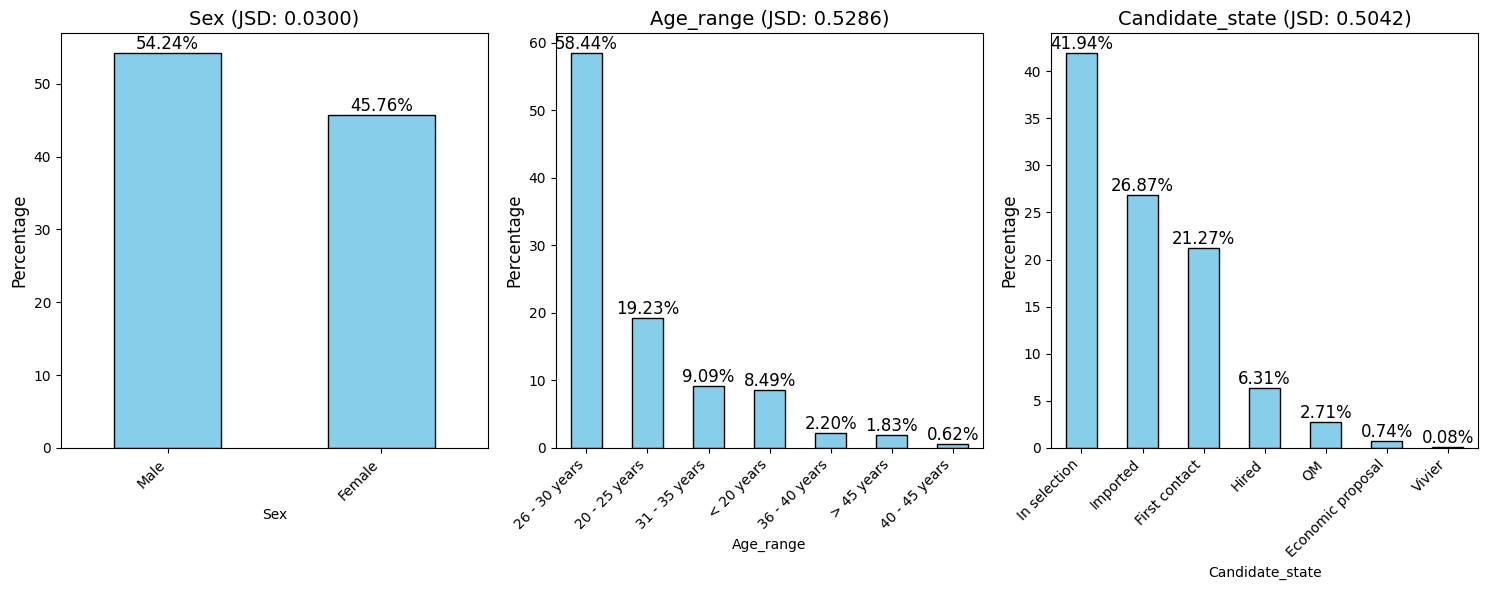

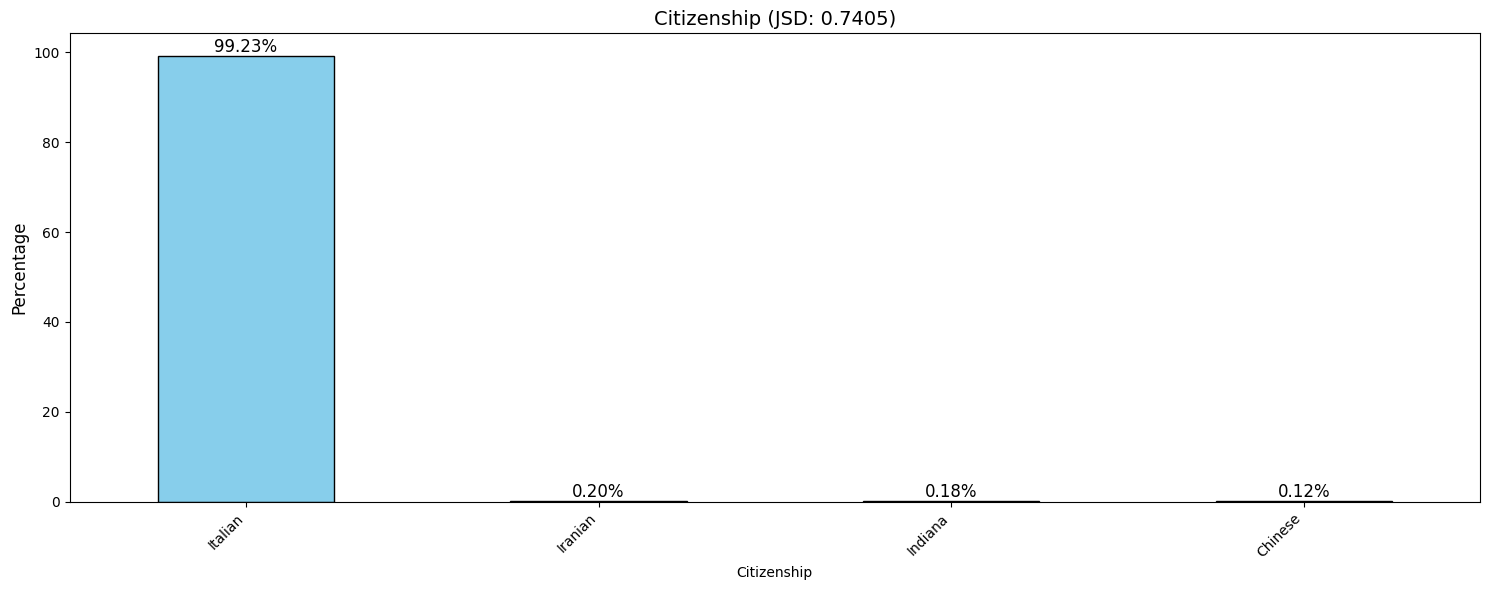

In [ ]:
columns_to_evaluate = ['Sex', 'Age_range','Candidate_state']
evaluate_and_plot_columns(synthetic_data3, columns_to_evaluate)

columns_to_evaluate = ['Citizenship']
evaluate_and_plot_columns(synthetic_data3, columns_to_evaluate, c=15)

KL Divergence with the sampled dataset with equal genders

                     Column  KL Divergence
0                       Sex       0.003603
22       Protected_Category       0.009679
16                 Mobility       0.013481
21                 Dynamism       0.014184
20                 Maturity       0.014916
19             Comunication       0.015393
17         Technical_Skills       0.015406
18        Standing_Position       0.015869
12                  Overall       0.026556
8       Year_of_Recruitment       0.035871
11           event_feedback       0.040940
2                 Age_range       0.043668
6          Years_Experience       0.047187
10          event_type__val       0.048286
13     Akkodis_headquarters       0.051523
27  Assumption_Headquarters       0.056769
7         Year_of_insertion       0.056911
9         Job_Family_Hiring       0.058635
26              Study_Level       0.068669
4               Study_Title       0.073116
24       Years_Experience_1       0.075791
14              Current_Ral       0.086909
25         

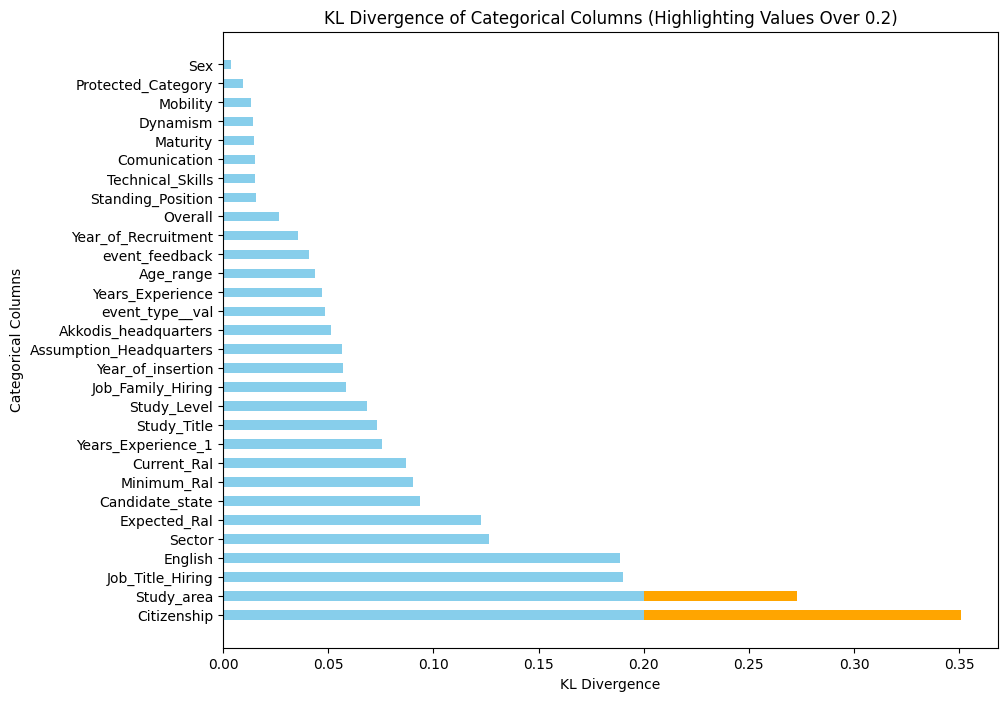

In [ ]:
original_data = data_equal
synthetic_data = synthetic_data3

results = []
for col in categorical_columns:
    kl_div = calculate_kl_divergence(original_data[col], synthetic_data[col])
    results.append({"Column": col, "KL Divergence": kl_div})

show_kl_result(results)

KL Divergence with the main dataset

                     Column  KL Divergence
22       Protected_Category       0.009314
20                 Maturity       0.010137
18        Standing_Position       0.010423
19             Comunication       0.010507
16                 Mobility       0.011246
21                 Dynamism       0.011426
17         Technical_Skills       0.013518
12                  Overall       0.022470
8       Year_of_Recruitment       0.028013
10          event_type__val       0.033449
9         Job_Family_Hiring       0.038265
13     Akkodis_headquarters       0.051612
2                 Age_range       0.059030
11           event_feedback       0.060848
7         Year_of_insertion       0.062980
27  Assumption_Headquarters       0.063969
1           Candidate_state       0.068827
26              Study_Level       0.072101
6          Years_Experience       0.074364
4               Study_Title       0.082435
25              Minimum_Ral       0.082926
24       Years_Experience_1       0.083790
14         

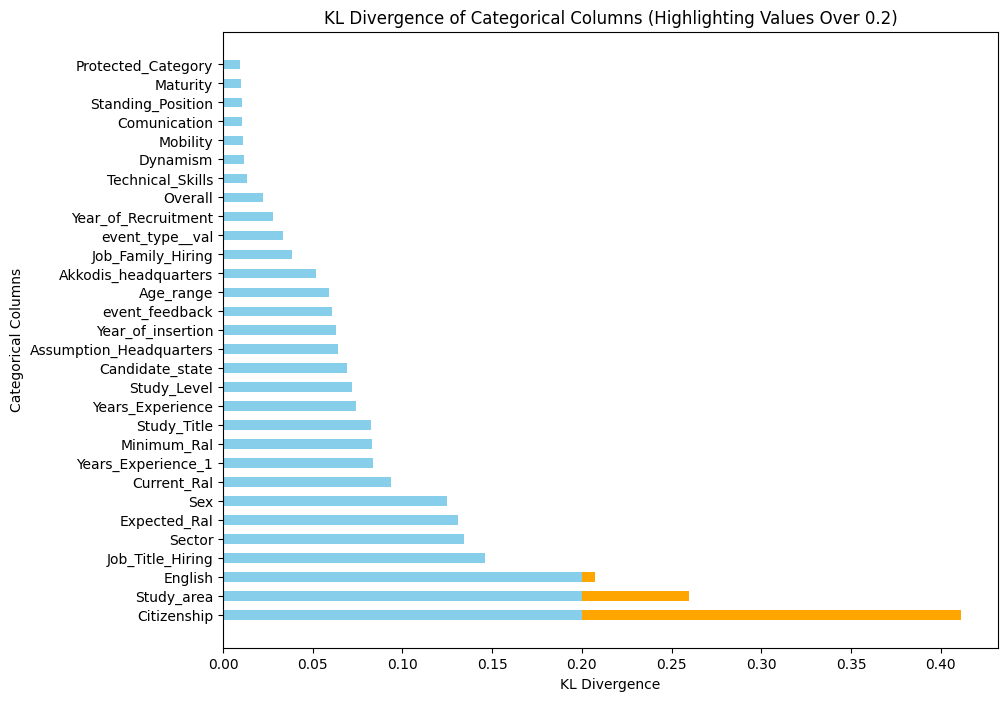

In [ ]:
original_data = data
synthetic_data = synthetic_data3

results = []
for col in categorical_columns:
    kl_div = calculate_kl_divergence(original_data[col], synthetic_data[col])
    results.append({"Column": col, "KL Divergence": kl_div})

show_kl_result(results)